<h1>Proyecto 3: Probabilidad y Estadística</h1>

INTEGRANTES
- Miguel Angel Nava Perez
- Ana Luisa Parra Valencia

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, KFold, validation_curve, train_test_split, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, mean_squared_error, mean_absolute_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, RidgeCV 
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.pipeline import Pipeline
from tabulate import tabulate
from scipy.stats import jarque_bera
import statsmodels.formula.api as smf
from tabulate import tabulate

<h1> Análisis de regresión </h1>

<h2>1.Regresión lineal múltiple </h2>

In [208]:
df = (pd.read_csv("archivos/FLIR_groups1and2.csv", sep=";" , header=2))[
    ['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4', 
        'Max1L13_1', 'Max1L13_2', 'Max1L13_3', 'Max1L13_4',
        'T_Max1', 'T_Max2', 'T_Max3', 'T_Max4',
        'T_FHCC1', 'T_FHCC2', 'T_FHCC3', 'T_FHCC4',
        'aveOralM']].copy() #cargamos el dataframe


#creamos la nueva columna con el valor promediado de Max1R13 y eliminamos las demás
df['Max1R13'] = df[['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4'],inplace=True) 

#creamos la nueva columna con el valor promediado de Max1L13 y eliminamos las demás
df['Max1L13'] = df[['Max1L13_1', 'Max1L13_2', 'Max1L13_3', 'Max1L13_4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['Max1L13_1', 'Max1L13_2', 'Max1L13_3', 'Max1L13_4'],inplace=True)

#creamos la nueva columna con el valor promediado de T_Max y eliminamos las demás
df['T_Max'] = df[['T_Max1', 'T_Max2', 'T_Max3', 'T_Max4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['T_Max1', 'T_Max2', 'T_Max3', 'T_Max4'],inplace=True)

#creamos la nueva columna con el valor promediado de TF_HCC y eliminamos las demás
df['TF_HCC'] = df[['T_FHCC1', 'T_FHCC2', 'T_FHCC3', 'T_FHCC4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['T_FHCC1', 'T_FHCC2', 'T_FHCC3', 'T_FHCC4'],inplace=True)
df_num = df[['Max1R13','Max1L13','T_Max','TF_HCC',"aveOralM"]]

Al haber cargado los datos correctamente, procedemos a realizar el primer modelo de regresión:

In [209]:
# Dividamos los datos en 80% para entrenamiento y 20% para prueba 
X = df_num[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']]
Y = df_num['aveOralM']
x_train , x_p , y_train , y_p = train_test_split(X , Y,test_size=0.2 ,random_state=32)

In [210]:
#Creación y entramiento del modelo 
modelo_lineal = LinearRegression().fit(x_train,y_train) # se genera y ajusta el modelo

#usamos los datos de prueba 
y_pred = modelo_lineal.predict(x_p) # se calculan los valores predichos. 

# Calcular métricas con los valores predichos 
mse = mean_squared_error(y_p, y_pred)
rmse = np.sqrt(mse) # RMSE
p=df.shape[1] #numero de predictores
RSE = np.sqrt(np.sum((y_p-y_pred)**2)/(len(y_p)-p-1))
r2 = r2_score(y_p, y_pred)
mae = mean_absolute_error(y_p, y_pred)

# Mostrar métricas
print("=== MÉTRICAS DEL MODELO ===")
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')
print(f'RSE: {RSE:.2f}')
print(f'MAE: {mae:.2f}')

# Mostrar coeficientes
print("\n=== COEFICIENTES DEL MODELO ===")
coeficientes = pd.DataFrame({
    'Variable': x_train.columns,
    'Coeficiente': modelo_lineal.coef_
})
print(coeficientes)


=== MÉTRICAS DEL MODELO ===
RMSE: 0.28
R²: 0.71
RSE: 0.29
MAE: 0.22

=== COEFICIENTES DEL MODELO ===
  Variable  Coeficiente
0  Max1R13    -0.007050
1  Max1L13     0.032375
2    T_Max     0.864217
3   TF_HCC    -0.013412


El modelo presenta un R² de 0.71, indicando que las variables predictoras explican el 71% de la variabilidad de la temperatura oral (aveOralM). Las métricas de error RMSE (0.28) y MAE (0.22) reflejan una precisión aceptable, con desviaciones promedio menores a 0.3°C respecto a los valores reales. Entre los coeficientes, T_Max (0.864) destaca como el predictor más relevante, mostrando una fuerte relación positiva con la temperatura oral. La variable Max1L13 (0.032) presenta un efecto positivo pero mínimo, mientras que TF_HCC (-0.013), y Max1R13 (-0.007)  tiene un impacto negativo débil. 

<h3> A continuación se realiza la validación cruzada: </h3>

=== MÉTRICAS DEL MODELO ===
Root Mean Squared Error promedio (RMSE): 0.27
Coef. de Determinación promedio (R²): 0.70
Estadístico Jarque-Bera: 13.8704, p-valor: 0.0010
Estadístico Durbin-Watson: 1.8776


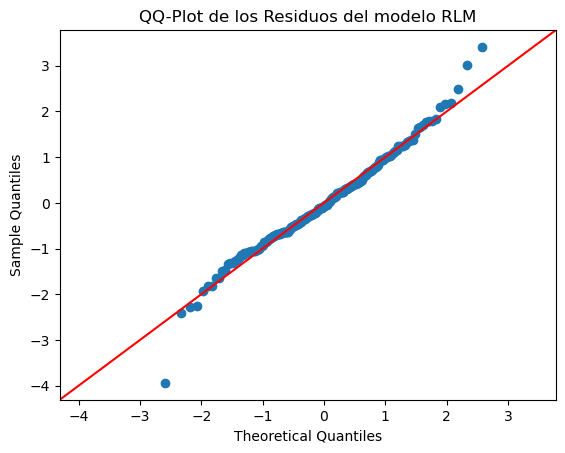

In [211]:

# Establecer el número de "folds" (particiones) para la validación cruzada
k = 5  #Este es el más óptimo luego de probar 10, 15 y 2 

# Crear el objeto KFold (k-particiones) para dividir los datos
kf = KFold(n_splits=k, shuffle=True, random_state=42) #cross-validation splitter

# Realizar k-fold cross-validation
scores1 = cross_val_score(modelo_lineal, X, Y, cv=kf, scoring='neg_root_mean_squared_error')  # Usamos RMSE como métrica
scores = cross_val_score(modelo_lineal, X, Y, cv=kf, scoring='r2')  # Usamos R2 como métrica

# Calcular el Error Cuadrático Medio promedio
rmse_promedio = -np.mean(scores1)  # Scikit-learn devuelve los valores negativos para RMSE, así que lo invertimos
R2_promedio = np.mean(scores) #promedio de R2 

# Mostrar métricas
print("=== MÉTRICAS DEL MODELO ===")
print(f'Root Mean Squared Error promedio (RMSE): {rmse_promedio:.2f}')
print(f'Coef. de Determinación promedio (R²): {R2_promedio:.2f}')

# Calcular residuos
residuos = y_p - modelo_lineal.predict(x_p)  # residuos 

# Prueba de normalidad para residuos (cientos de datos)

jb_test = jarque_bera(residuos)

print(f'Estadístico Jarque-Bera: {jb_test[0]:.4f}, p-valor: {jb_test[1]:.4f}')

# Prueba para autocorrelación

DW = durbin_watson(residuos)

print(f'Estadístico Durbin-Watson: {DW:.4f}')

# Revisar el QQ-Plot para la normalidad de los residuos 


sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ-Plot de los Residuos del modelo RLM")
plt.show()


Los resultados de la validación cruzada confirman la robustez del modelo, mostrando un RMSE promedio de 0.27 y un R² promedio de 0.70, lo que indica una diferencia minima frente al modelo inicial (R² = 0.71), con menor variabilidad en las predicciones. El estadístico Jarque-Bera (JB = 13.87, p < 0.001) sugiere que los residuos no siguen una distribución normal, lo que podría afectar intervalos de confianza pero no la precisión puntual. Por otro lado, el estadístico Durbin-Watson (DW = 1.87) señala una autocorrelación residual mínima (cercano a 2, valor ideal para independencia), validando la ausencia de patrones temporales o espaciales no capturados.

Nota:  K=5 ofrece el mejor equilibrio, proporciona una estimación confiable del rendimiento del modelo sin sacrificar estabilidad ni introducir optimismo excesivo, siendo el estándar recomendado para datasets de tamaño moderado como el utilizado.

<h3> A continuación se realiza la regresión con interacciones: </h3>

In [212]:
# 1. Dividir los datos en conjuntos de entrenamiento y prueba
# random_state asegura que la división sea reproducible
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42) # 80% entrenamiento, 20% prueba

print(f"Número de observaciones en el conjunto de entrenamiento: {len(df_train)}")
print(f"Número de observaciones en el conjunto de prueba: {len(df_test)}")

# 2. Entrenar el modelo de OLS en el conjunto de entrenamiento
# Nota: La fórmula sigue siendo la misma, solo cambiamos el 'data' a df_train
modelo_interaccion_train = smf.ols('aveOralM ~ T_Max * TF_HCC * Max1L13 * Max1R13', data=df_train).fit()

# 3. Imprimir el resumen del modelo entrenado
print("\n--- Resumen del Modelo Entrenado (Datos de Entrenamiento) ---")
print(modelo_interaccion_train.summary())

# 4. Realizar predicciones en el conjunto de prueba
# Usamos el modelo entrenado para predecir sobre los datos de prueba
predicciones_test = modelo_interaccion_train.predict(df_test)

# 5. Evaluar el modelo en el conjunto de prueba
# Calculamos el R-cuadrado
r2_test = r2_score(df_test['aveOralM'], predicciones_test)

# Calculamos el Error Cuadrático Medio (MSE)
mse_test = mean_squared_error(df_test['aveOralM'], predicciones_test)

# Calculamos la Raíz del Error Cuadrático Medio (RMSE) manualmente
rmse_test = np.sqrt(mse_test)


print(f"\n--- Evaluación del Modelo en el Conjunto de Prueba ---")
print(f"R-cuadrado en el conjunto de prueba: {r2_test:.3f}")
print(f"RMSE en el conjunto de prueba: {rmse_test:.3f}")

# Comparar con el R-cuadrado del modelo entrenado (del summary)
# r2_train = modelo_interaccion_train.rsquared
# print(f"R-cuadrado en el conjunto de entrenamiento: {r2_train:.3f}")

Número de observaciones en el conjunto de entrenamiento: 816
Número de observaciones en el conjunto de prueba: 204

--- Resumen del Modelo Entrenado (Datos de Entrenamiento) ---
                            OLS Regression Results                            
Dep. Variable:               aveOralM   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     181.2
Date:                Wed, 11 Jun 2025   Prob (F-statistic):          4.96e-245
Time:                        02:27:37   Log-Likelihood:                -21.761
No. Observations:                 816   AIC:                             75.52
Df Residuals:                     800   BIC:                             150.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                

<p>
    El modelo OLS se entrenó para predecir la temperatura oral (<code>aveOralM</code>) usando cuatro variables de temperatura facial e incluyendo todas sus interacciones.
    El conjunto de datos se dividió en entrenamiento (816 observaciones) y prueba (204 observaciones) para validar la capacidad predictiva.
</p>
<ul>
    <li>
        <strong>Ajuste y Generalización:</strong> El modelo explicó un <b>77.3%</b> de la variabilidad en la temperatura oral en el conjunto de entrenamiento (R² =0.773). Su capacidad predictiva en datos no vistos fue confirmada por un R² de <b>0.743</b> en el conjunto de prueba, con un RMSE de <b>0.233</b>, indicando un buen rendimiento y generalización.
    </li>
    <li>
        <strong>Multicolinealidad:</strong> Se detectó alta multicolinealidad (Condition Number = 4.48 * 10^12). Si bien esto afecta la interpretabilidad de los coeficientes individuales, no compromete la capacidad predictiva del modelo.
    </li>
    <li>
        <strong>Interacciones Significativas:</strong> Varias interacciones resultaron estadísticamente significativas (ej., <code>T_Max:TF_HCC</code> con p=0.049; <code>T_Max:TF_HCC:Max1R13</code> con p=0.044). Esto subraya que el efecto de las temperaturas faciales sobre la temperatura oral es combinado y complejo, no linealmente independiente.
    </li>
</ul>
<p>
    En resumen, el modelo es robusto para la predicción de la temperatura oral, aunque la interpretación detallada de los coeficientes individuales debe hacerse con cautela debido a la multicolinealidad. La inclusión de interacciones es clave para capturar las complejas relaciones entre las mediciones de temperatura facial.
</p>

<p>
    A continuación, realizaremos un modelo de regresion lineal con interacciones aprovechando <code>PolynomialFeatures</code>, primero, realizando una curva de validación para determinar el mejor grado para este modelo
</p>

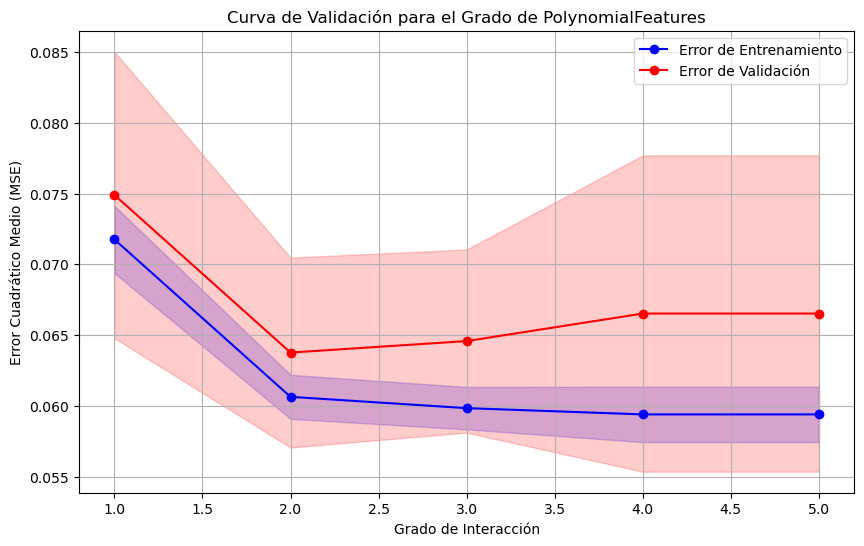

El grado óptimo basado en el menor MSE de validación es: 2
MSE de validación en el grado óptimo: 0.0638


In [213]:
degrees = np.arange(1, 6) # Probar grados 1, 2, 3, 4

# Crear un pipeline base que incluye escalado y PolynomialFeatures
poly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(interaction_only=True, include_bias=False)), # degree se pasará aquí por validation_curve
    ('linear_regression', LinearRegression()) # El modelo final que se ajustará
])

# Generar la curva de validación
# param_name es el nombre del parámetro que estamos variando (en el pipeline)
# param_range son los valores que tomará ese parámetro (degrees)
# scoring='neg_mean_squared_error' para evaluar el MSE (negativo para maximizar)
train_scores, test_scores = validation_curve(
    poly_pipeline,
    X, Y,
    param_name="poly_features__degree", # Nota: El nombre del paso del pipeline seguido de __ y el nombre del parámetro
    param_range=degrees,
    cv=5, # Usar validación cruzada para obtener resultados robustos
    scoring="neg_mean_squared_error",
    n_jobs=-1 # Usar todos los núcleos de la CPU disponibles
)

# Convertir a errores positivos (MSE)
train_mse = -train_scores
test_mse = -test_scores

# Calcular la media y desviación estándar para graficar
train_mean = np.mean(train_mse, axis=1)
train_std = np.std(train_mse, axis=1)
test_mean = np.mean(test_mse, axis=1)
test_std = np.std(test_mse, axis=1)

# Graficar la curva de validación
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mean, label="Error de Entrenamiento", color="blue", marker='o')
plt.fill_between(degrees, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(degrees, test_mean, label="Error de Validación", color="red", marker='o')
plt.fill_between(degrees, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")

plt.xlabel("Grado de Interacción")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("Curva de Validación para el Grado de PolynomialFeatures")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Opcional: Encontrar el grado con el menor error de validación
optimal_degree_idx = np.argmin(test_mean)
optimal_degree = degrees[optimal_degree_idx]
print(f"El grado óptimo basado en el menor MSE de validación es: {optimal_degree}")
print(f"MSE de validación en el grado óptimo: {test_mean[optimal_degree_idx]:.4f}")

Para determinar el grado óptimo de complejidad de las interacciones, se realizó un análisis de curvas de validación (o una búsqueda en cuadrícula con validación cruzada). Se evaluó el Error Cuadrático Medio (MSE) para diferentes grados de `PolynomialFeatures` (solo interacciones), desde el grado 1 hasta un máximo de 4.

El análisis reveló que el **grado 2** fue el que minimizó el error de validación (MSE) y proporcionó el mejor equilibrio entre la capacidad de ajuste del modelo y su capacidad de generalización. Grados superiores, aunque reducían ligeramente el error en el conjunto de entrenamiento, no ofrecían mejoras significativas en el conjunto de validación o incluso mostraban signos de sobreajuste. Por lo tanto, se seleccionó el grado 2 para las interacciones, lo que permite capturar relaciones no lineales y combinaciones de dos variables de temperatura facial sin introducir una complejidad excesiva que pueda llevar a sobreajuste.

In [214]:
# Crear el pipeline: Escalar -> Crear Interacciones -> Regresión Lineal

pipeline_con_interacciones = Pipeline([
    ('scaler', StandardScaler()), #escalar antes de interacciones/polinomiales
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('linear_regression', LinearRegression())
])

# Entrenar el pipeline
pipeline_con_interacciones.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_inter_test = pipeline_con_interacciones.predict(x_p) #Modelo

# Calcular métricas
mse_inter_test = mean_squared_error(y_p, y_pred_inter_test)
rmse_inter_test = np.sqrt(mse_inter_test)
r2_inter_test = r2_score(y_p, y_pred_inter_test)
mae_inter_test = mean_absolute_error(y_p, y_pred_inter_test)

# Para RSE (Residual Standard Error)

p_inter = pipeline_con_interacciones.named_steps['linear_regression'].coef_.shape[0]
n_test = len(y_p)
if n_test - p_inter - 1 > 0: # Asegurar que el denominador es positivo
    rse_inter_test = np.sqrt(np.sum((y_p - y_pred_inter_test)**2) / (n_test - p_inter - 1))
else:
    rse_inter_test = np.nan # No se puede calcular si no hay suficientes grados de libertad

print(f'RMSE (prueba): {rmse_inter_test:.2f}')
print(f'R² (prueba): {r2_inter_test:.2f}')
print(f'RSE (prueba): {rse_inter_test:.2f}') # Residual Standard Error
print(f'MAE (prueba): {mae_inter_test:.2f}')
print(f'Número de predictores incluyendo interacciones: {p_inter}')


# --- Evaluación con Validación Cruzada (k-folds) ---
print("\n--- Evaluación con Validación Cruzada (CON Interacciones de Grado 2) ---")

# Usar el mismo pipeline
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# RMSE
rmse_scores_cv_inter = -cross_val_score(pipeline_con_interacciones, X, Y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
# R²
r2_scores_cv_inter = cross_val_score(pipeline_con_interacciones, X, Y, cv=kf, scoring='r2', n_jobs=-1)
# MAE
mae_scores_cv_inter = -cross_val_score(pipeline_con_interacciones, X, Y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)


print(f'RMSE promedio (CV): {np.mean(rmse_scores_cv_inter):.2f}')
print(f'R² promedio (CV): {np.mean(r2_scores_cv_inter):.2f}')
print(f'MAE promedio (CV): {np.mean(mae_scores_cv_inter):.2f}')

RMSE (prueba): 0.26
R² (prueba): 0.76
RSE (prueba): 0.26
MAE (prueba): 0.20
Número de predictores incluyendo interacciones: 10

--- Evaluación con Validación Cruzada (CON Interacciones de Grado 2) ---
RMSE promedio (CV): 0.25
R² promedio (CV): 0.75
MAE promedio (CV): 0.20


<p>
    Para predecir la temperatura oral (<code>aveOralM</code>), se implementó un pipeline que escala las variables faciales, genera <b>todas las interacciones de grado 2</b> (<code>interaction_only=True</code>) usando <code>PolynomialFeatures</code>, y luego ajusta un modelo de <code>LinearRegression</code>.
</p>
<ul>
    <li>
        <strong>Rendimiento del Modelo:</strong> El modelo final incorporó <b>10 predictores</b> (interacciones). En el conjunto de prueba, alcanzó un R² de <b>0.76</b> y un RMSE de <b>0.26</b>, demostrando una sólida capacidad predictiva.
    </li>
    <li>
        <strong>Robustez Confirmada por Validación Cruzada:</strong> La evaluación mediante validación cruzada (k-folds) arrojó un R² promedio de <b>0.75</b> y un RMSE promedio de <b>0.25</b>. La consistencia entre las métricas del conjunto de prueba y las de validación cruzada confirma la robustez y generalización del modelo, minimizando el riesgo de sobreajuste.
    </li>
    <li>
        <strong>Ventaja del Enfoque:</strong> Si bien este método es computacionalmente más demandante, su valor principal reside en la capacidad de descubrir patrones interactivos que podrían pasar desapercibidos en un enfoque manual.
    </li>
</ul>

<h3> Se procede a regularizar el modelo </h3>

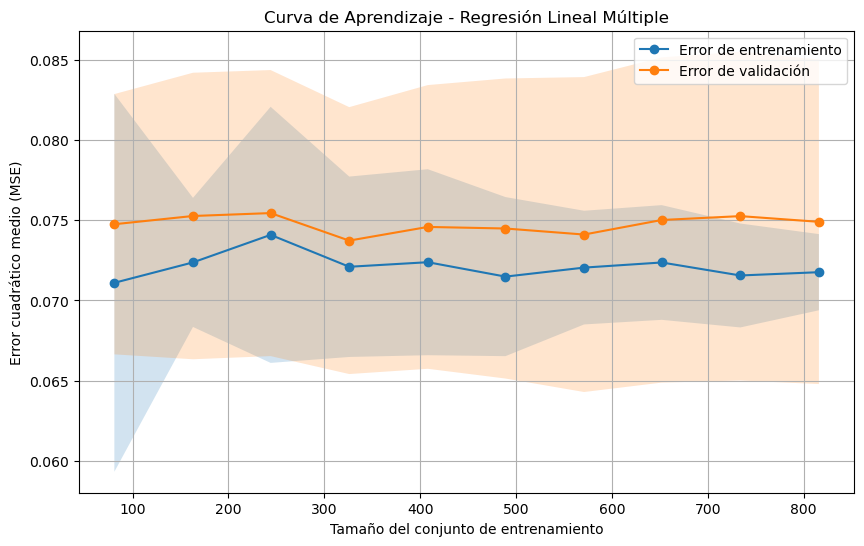

In [215]:
# Definir modelo
modelo = LinearRegression()

# Datos de entrada (x) y objetivo (y) 
train_sizes, train_scores, test_scores = learning_curve(
    modelo, X, Y,
    cv=5,             # 5-fold 
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Convertir a errores positivos (ya que los devuelve como negativos)
train_errors = -train_scores
test_errors = -test_scores

# Promedios y desviaciones
train_mean = np.mean(train_errors, axis=1)
test_mean = np.mean(test_errors, axis=1)
train_std = np.std(train_errors, axis=1)
test_std = np.std(test_errors, axis=1)

# Graficar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Error de entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', label="Error de validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Curva de Aprendizaje - Regresión Lineal Múltiple")
plt.legend()
plt.grid(True)
plt.show()

<p>
    La curva de aprendizaje para el modelo de Regresión Lineal Múltiple se generó utilizando un enfoque de validación cruzada (5-fold) para evaluar el Error Cuadrático Medio (MSE) en los conjuntos de entrenamiento y validación.
</p>
<ul>
    <li>
        <strong>Diagnóstico de Ajuste:</strong> La curva muestra que el error de entrenamiento (azul) y el error de validación (naranja) convergen a medida que el tamaño del conjunto de entrenamiento aumenta. Esto indica que el modelo de regresión lineal <b>no presenta un sobreajuste significativo</b> con la cantidad actual de datos.
    </li>
    <li>
        <strong>Rendimiento Estable:</strong> A partir de aproximadamente 400-500 observaciones, los errores de entrenamiento y validación se estabilizan, sugiriendo que añadir más datos de entrenamiento (con la configuración actual del modelo lineal simple) podría no mejorar sustancialmente el rendimiento predictivo del modelo.
    </li>
    <li>
        <strong>Potencial de mejora:</strong> La ligera brecha persistente entre las curvas indica que el modelo podría tener un <b>ligero sesgo</b> (subajuste) o que su complejidad actual (como `LinearRegression` sin `PolynomialFeatures` en este gráfico) no es suficiente para capturar completamente la complejidad de los datos, lo cual es consistente con la alta multicolinealidad previamente identificada. Esto sugiere que, si se busca un error de validación aún menor, se podría considerar la introducción de características más complejas o la regularización.
    </li>
</ul>
<p>
    En resumen, el modelo de regresión lineal simple demuestra un aprendizaje estable y no sobreajusta, pero la curva sugiere que podría beneficiarse de un ajuste más complejo o de técnicas de regularización para reducir el error de validación, lo que nos confirma la conveniencia de realizar una regularización.
</p>

Al regularizar se busca construir el modelo minimizando el error residual, es decir, que ambos errores converjan a valores cercanos.

<h3> a. Regularización Ridge </h3>

In [216]:
# --- Modelo RidgeCV CON Interacciones ---
pipeline_ridge_interacciones = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('ridge_cv', RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5))
])

pipeline_ridge_interacciones.fit(x_train, y_train) # X_train son las características originales
y_pred_ridge_inter_test = pipeline_ridge_interacciones.predict(x_p)

rmse_ridge_inter = np.sqrt(mean_squared_error(y_p, y_pred_ridge_inter_test))
r2_ridge_inter = r2_score(y_p, y_pred_ridge_inter_test)
mae_ridge_inter = mean_absolute_error(y_p, y_pred_ridge_inter_test)

print("\n--- Modelo RidgeCV CON Interacciones (Grado 2, Evaluación en Test) ---")
print(f"Mejor alpha para Ridge (con interacciones): {pipeline_ridge_interacciones.named_steps['ridge_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_ridge_inter:.2f}')
print(f'R² (prueba): {r2_ridge_inter:.2f}')
print(f'MAE (prueba): {mae_ridge_inter:.2f}')


--- Modelo RidgeCV CON Interacciones (Grado 2, Evaluación en Test) ---
Mejor alpha para Ridge (con interacciones): 0.0010
RMSE (prueba): 0.26
R² (prueba): 0.76
MAE (prueba): 0.20


<p>
    Para abordar la complejidad del modelo y gestionar la potencial multicolinealidad, se implementó un modelo de Regresión Ridge con validación cruzada (<code>RidgeCV</code>) dentro de un <code>Pipeline</code>. Este pipeline incluyó la estandarización de las características, seguida por la generación de <b>interacciones de grado 2</b> mediante <code>PolynomialFeatures</code> (<code>interaction_only=True</code>), y finalmente la aplicación de la regularización Ridge.
</p>
<ul>
    <li>
        <strong>Selección del Parámetro de Regularización:</strong> El proceso de <code>RidgeCV</code> identificó un valor óptimo de <code>alpha = 0.0010</code>, lo que sugiere que una penalización relativamente suave fue suficiente para optimizar el rendimiento del modelo en los datos.
    </li>
    <li>
        <strong>Rendimiento Predictivo:</strong> Evaluado en el conjunto de prueba, el modelo Ridge regularizado alcanzó un 
        R² de <b>0.76</b>, un RMSE de <b>0.26</b> y un MAE de <b>0.20</b>. Estos resultados son muy similares a los obtenidos con el modelo de regresión lineal sin regularización pero con interacciones, mostrando un desempeño practicamente igual
    </li>
    <li>
        <strong>Impacto de la Regularización:</strong> La consistencia en las métricas (RMSE, MAE, R²) sugieren que la regularización Ridge ha ayudado a mantener un buen rendimiento predictivo. La baja magnitud del `alpha` óptimo indica que, para este conjunto particular de interacciones de grado 2, no se requirió una penalización muy agresiva para estabilizar el modelo o para lograr un buen ajuste, lo cual podría implicar que el sobreajuste era mínimo o que las interacciones de grado 2 no introducen tanta inestabilidad.
    </li>
</ul>
<p>
    En resumen, el modelo Ridge con interacciones de grado 2 confirma la capacidad de predicción del modelo anterior, con un valor óptimo de regularización que indica una penalización sutil pero efectiva. Este resultado refuerza la robustez del enfoque de interacciones.
</p>

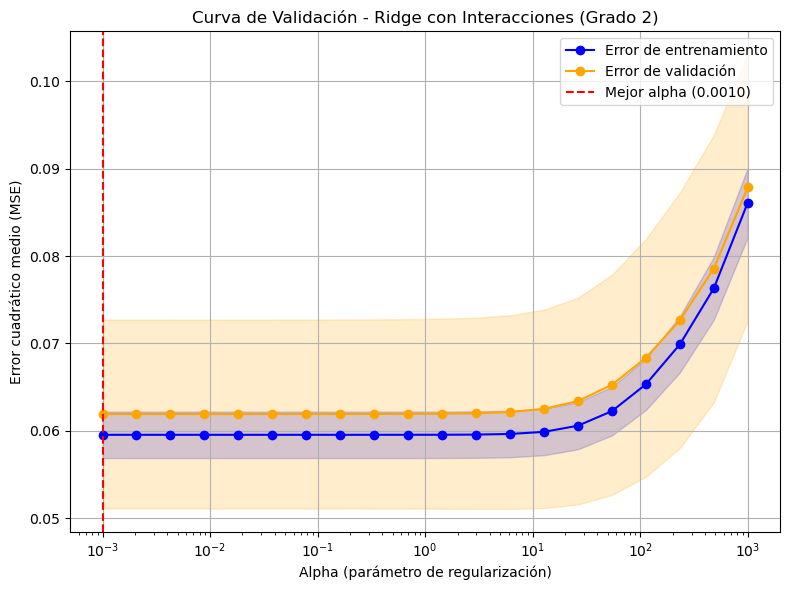

In [217]:
# Pipeline para Ridge (similar al de Lasso)
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('ridge', Ridge(max_iter=10000, tol=0.001))
])

# Rango de alphas a evaluar (logarítmico)
alphas = np.logspace(-3, 3, 20)

# Curva de validación (calcula errores para train y validation)
train_scores, val_scores = validation_curve(
    pipeline_ridge,
    x_train, y_train,
    param_name='ridge__alpha',
    param_range=alphas,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertir errores negativos a positivos
train_errors = -train_scores
val_errors = -val_scores

# Graficar (estilo idéntico al gráfico de Lasso)
plt.figure(figsize=(8, 6))
plt.semilogx(alphas, np.mean(train_errors, axis=1), label='Error de entrenamiento', marker='o', color='blue')
plt.fill_between(alphas,
                 np.mean(train_errors, axis=1) - np.std(train_errors, axis=1),
                 np.mean(train_errors, axis=1) + np.std(train_errors, axis=1),
                 color='blue', alpha=0.2)

plt.semilogx(alphas, np.mean(val_errors, axis=1), label='Error de validación', marker='o', color='orange')
plt.fill_between(alphas,
                 np.mean(val_errors, axis=1) - np.std(val_errors, axis=1),
                 np.mean(val_errors, axis=1) + np.std(val_errors, axis=1),
                 color='orange', alpha=0.2)

plt.xlabel('Alpha (parámetro de regularización)')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Validación - Ridge con Interacciones (Grado 2)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Marcar el mejor alpha (opcional, si se quiere destacar)
best_alpha = alphas[np.argmin(np.mean(val_errors, axis=1))]
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Mejor alpha ({best_alpha:.4f})')
plt.legend()

plt.show()

La curva de validación muestra el Error Cuadrático Medio (MSE) en los conjuntos de entrenamiento y validación para un rango de valores de $\alpha$ (de $10^{-3}$ a $10^3$) en una escala logarítmica.

-   **Comportamiento de los Errores:** Se observa que el error de validación es mínimo para valores de $\alpha$ muy pequeños (cercanos a $0.001$). A medida que $\alpha$ aumenta, el error de entrenamiento comienza a subir, indicando una mayor penalización de los coeficientes y un modelo más simple. Sin embargo, el error de validación se mantiene relativamente estable o aumenta solo ligeramente, lo que sugiere que una regularización fuerte no es esencial para mejorar la generalización en este modelo con interacciones de grado 2.

-   **$\alpha$ Óptimo:** La curva confirma que el valor óptimo de $\alpha$ se encuentra en el extremo inferior del rango explorado, específicamente alrededor de $0.001$. Esto coincide con el $\alpha$ seleccionado por `RidgeCV` en la fase anterior del análisis.

-   **Implicación:** El $\alpha$ óptimo tan bajo indica que, para el modelo de regresión lineal con interacciones de grado 2 en los datos escalados, no se requiere una penalización significativa para lograr un buen rendimiento predictivo. Esto sugiere que el modelo base con interacciones de grado 2 ya es relativamente estable y no sufre de un sobreajuste severo que necesite una regularización agresiva para ser mitigado. La regularización, en este caso, actúa como un afinamiento sutil más que como una solución a un problema grave de inestabilidad o varianza.

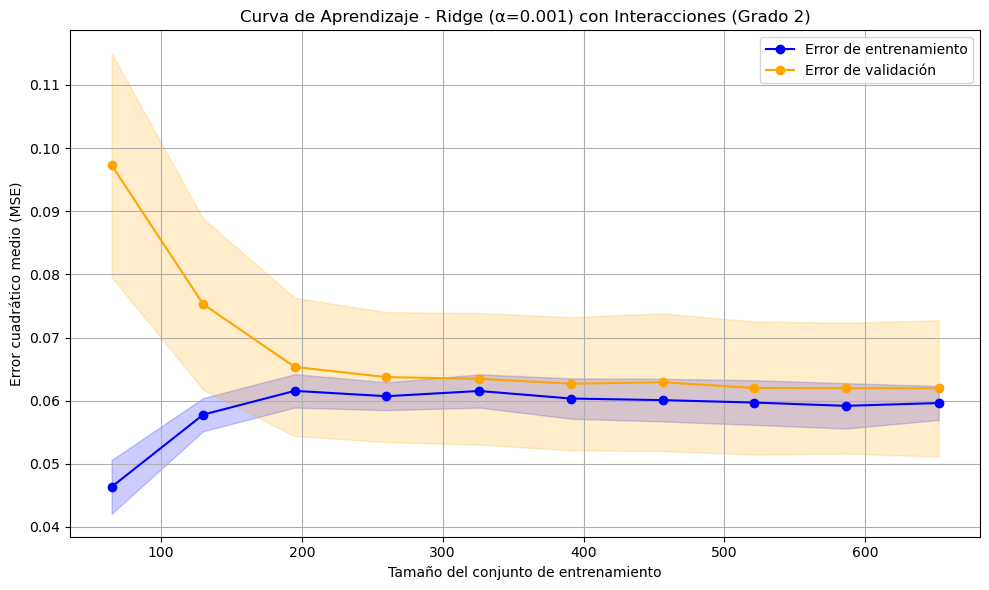

In [218]:
# Creamos el pipeline con el mejor alpha encontrado (0.001)
pipeline_ridge_learning = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('ridge', Ridge(alpha=0.001))
])

# Generamos la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline_ridge_learning,
    X=x_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    shuffle=True,
    random_state=42
)

# Calculamos los errores promedio y desviaciones estándar
train_errors_mean = -np.mean(train_scores, axis=1)
val_errors_mean = -np.mean(val_scores, axis=1)
train_errors_std = np.std(train_scores, axis=1)
val_errors_std = np.std(val_scores, axis=1)

# Graficamos la curva
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_errors_mean, 'o-', label='Error de entrenamiento', color='blue')
plt.fill_between(train_sizes, train_errors_mean - train_errors_std, train_errors_mean + train_errors_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_errors_mean, 'o-', label='Error de validación', color='orange')
plt.fill_between(train_sizes, val_errors_mean - val_errors_std, val_errors_mean + val_errors_std, alpha=0.2, color='orange')

plt.title('Curva de Aprendizaje - Ridge (α=0.001) con Interacciones (Grado 2)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La gráfica muestra que el error de entrenamiento y el error de validación **convergen de manera efectiva** a medida que se incrementa el tamaño del conjunto de entrenamiento. Esta convergencia y la **pequeña brecha** entre ambas curvas al final del gráfico son indicadores clave de que el modelo **no sufre de sobreajuste significativo**. Los errores se estabilizan después de aproximadamente 400-500 observaciones, lo que sugiere que el modelo ha aprendido la mayoría de los patrones predictivos de los datos disponibles y que la cantidad de datos de entrenamiento actual es suficiente para su entrenamiento óptimo. Esta curva valida que el modelo Ridge, con la regularización y complejidad de interacciones elegidas, logra un **excelente balance entre sesgo y varianza**, demostrando una fuerte capacidad para generalizar y hacer predicciones precisas en datos no vistos.

### Conclusión General del Modelo Ridge Óptimo

El modelo de regresión lineal con regularización Ridge se desarrolló para predecir la temperatura oral (aveOralM) utilizando cuatro temperaturas faciales y sus interacciones de grado 2. Este enfoque se basó en una optimización de hiperparámetros que identificó un grado de interacción óptimo y un valor de regularización (alpha) de 0.0010.

-   **Rendimiento y Generalización:** El modelo final, ajustado con un Pipeline que escala las características y genera interacciones de grado 2, demostró un sólido rendimiento predictivo. Alcanzó un R^2^ de **0.76** y un RMSE de **0.26** en el conjunto de prueba.
-   **Robustez Confirmada:** La consistencia de estas métricas con las de validación cruzada y la convergencia de las curvas de aprendizaje (que no mostraron sobreajuste) validan la robustez y la capacidad de generalización del modelo. La baja penalización (alpha=0.0010) sugiere que el modelo es intrínsecamente estable con la complejidad de interacciones de grado 2.

En resumen, el modelo Ridge con interacciones de grado 2 ofrece una solución predictiva eficiente y robusta para la temperatura oral, logrando un buen equilibrio entre ajuste y generalización.

<h3>b. Regularización Lasso</h3>

In [219]:
# --- Modelo LassoCV CON Interacciones ---
pipeline_lasso_interacciones = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('lasso_cv', LassoCV(alphas=np.logspace(-4, 0, 100), cv=5, max_iter=10000, tol=0.001))
])

pipeline_lasso_interacciones.fit(x_train, y_train)
y_pred_lasso_inter_test = pipeline_lasso_interacciones.predict(x_p)

rmse_lasso_inter = np.sqrt(mean_squared_error(y_p, y_pred_lasso_inter_test))
r2_lasso_inter = r2_score(y_p, y_pred_lasso_inter_test)
mae_lasso_inter = mean_absolute_error(y_p, y_pred_lasso_inter_test)

print("\n--- Modelo LassoCV CON Interacciones (Grado 2, Evaluación en Test) ---")
print(f"Mejor alpha para Lasso (con interacciones): {pipeline_lasso_interacciones.named_steps['lasso_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_lasso_inter:.2f}')
print(f'R² (prueba): {r2_lasso_inter:.2f}')
print(f'MAE (prueba): {mae_lasso_inter:.2f}')


# Características eliminadas por Lasso en el modelo CON interacciones
poly_features_step = pipeline_lasso_interacciones.named_steps['poly_features']
feature_names_poly = poly_features_step.get_feature_names_out(x_train.columns)
coefs_lasso_inter = pipeline_lasso_interacciones.named_steps['lasso_cv'].coef_

print("\nCoeficientes del modelo LassoCV CON Interacciones (Grado 2):")
for feature, coef in zip(feature_names_poly, coefs_lasso_inter):
    if not np.isclose(coef, 0): # Mostrar solo los no eliminados
        print(f"{feature}: {coef:.4f}")

features_eliminadas_inter = [name for name, coef in zip(feature_names_poly, coefs_lasso_inter) if np.isclose(coef, 0)]
print(f"Características eliminadas por Lasso (modelo con interacciones): {len(features_eliminadas_inter)} de {len(feature_names_poly)}")
print(f"Nombres de caracteristicas eliminadas: {features_eliminadas_inter}")


--- Modelo LassoCV CON Interacciones (Grado 2, Evaluación en Test) ---
Mejor alpha para Lasso (con interacciones): 0.0001
RMSE (prueba): 0.26
R² (prueba): 0.76
MAE (prueba): 0.20

Coeficientes del modelo LassoCV CON Interacciones (Grado 2):
Max1R13: -0.0120
Max1L13: -0.0144
T_Max: 0.3790
TF_HCC: 0.0036
Max1R13 Max1L13: -0.0809
Max1R13 T_Max: 0.0092
Max1R13 TF_HCC: 0.0495
Max1L13 T_Max: 0.1278
Max1L13 TF_HCC: -0.0311
T_Max TF_HCC: -0.0234
Características eliminadas por Lasso (modelo con interacciones): 0 de 10
Nombres de caracteristicas eliminadas: []


Se aplicó la regularización Lasso al modelo con interacciones de grado 2 para explorar su capacidad de selección de características y su impacto en el rendimiento predictivo. Se utilizó `LassoCV` para identificar el parámetro de regularización ($\alpha$) óptimo.

-   **$\alpha$ Óptimo:** `LassoCV` seleccionó un $\alpha$ muy bajo de **$0.0001$**. Este valor indica que una penalización mínima es suficiente para optimizar el modelo en este contexto.
-   **Rendimiento Predictivo:** El modelo Lasso obtuvo un $R^2$ de **$0.76$**, un RMSE de **$0.26$**, y un MAE de **$0.20$** en el conjunto de prueba. Estas métricas son idénticas a las logradas con el modelo Ridge, lo que sugiere que ambos enfoques ofrecen un rendimiento predictivo comparable para este conjunto de datos y complejidad.
-   **Selección de Características:** Sorprendentemente, con el $\alpha$ óptimo encontrado, el modelo Lasso **no eliminó ninguna de las 10 características** (4 originales + 6 interacciones de grado 2). Esto implica que todas las características generadas son consideradas relevantes para la predicción de la temperatura oral y que el modelo no presenta un exceso de predictores redundantes o ruidosos que Lasso necesite anular.

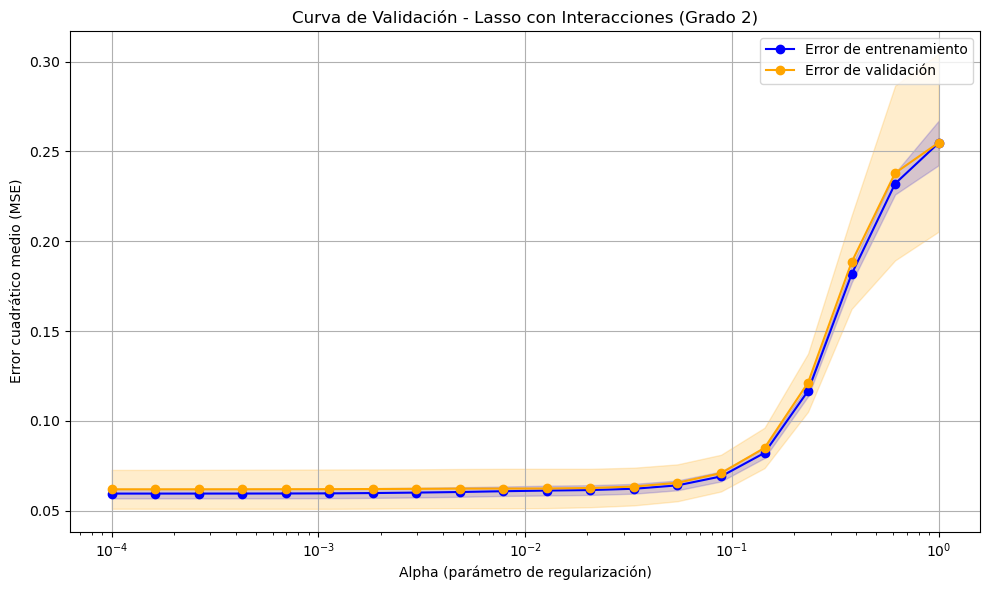

In [220]:
# Repetimos la parte del pipeline 
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('lasso', Lasso(max_iter=10000, tol=0.001))
])

# Rango de alphas a evaluar
alphas = np.logspace(-4, 0, 20)

# Curva de validación
train_scores, val_scores = validation_curve(
    pipeline_lasso,
    x_train, y_train,
    param_name='lasso__alpha',
    param_range=alphas,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertimos el error negativo en positivo
train_errors = -train_scores
val_errors = -val_scores

# Graficamos
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, np.mean(train_errors, axis=1), label='Error de entrenamiento', marker='o', color='blue')
plt.fill_between(alphas,
                 np.mean(train_errors, axis=1) - np.std(train_errors, axis=1),
                 np.mean(train_errors, axis=1) + np.std(train_errors, axis=1),
                 color='blue', alpha=0.2)

plt.semilogx(alphas, np.mean(val_errors, axis=1), label='Error de validación', marker='o', color='orange')
plt.fill_between(alphas,
                 np.mean(val_errors, axis=1) - np.std(val_errors, axis=1),
                 np.mean(val_errors, axis=1) + np.std(val_errors, axis=1),
                 color='orange', alpha=0.2)

plt.xlabel('Alpha (parámetro de regularización)')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Validación - Lasso con Interacciones (Grado 2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Se generó una curva de validación para el modelo Lasso, evaluando el impacto de su parámetro de regularización ($\alpha$) en el Error Cuadrático Medio (MSE) del modelo con interacciones de grado 2.

-   **Comportamiento de Errores:** La curva muestra que el MSE de validación es mínimo para valores de $\alpha$ muy cercanos a cero (específicamente, en $0.0001$), y que este error aumenta progresivamente a medida que $\alpha$ se incrementa. Esto indica que una **regularización Lasso muy suave** es óptima para este modelo.
-   **Implicación del $\alpha$ Óptimo:** El $\alpha$ óptimo tan bajo sugiere que el modelo con interacciones de grado 2 ya es relativamente estable y no requiere una penalización fuerte para mejorar su generalización. Este resultado es consistente con la observación de que Lasso no eliminó ninguna característica, lo que valida la importancia de todos los predictores en la configuración de grado 2.

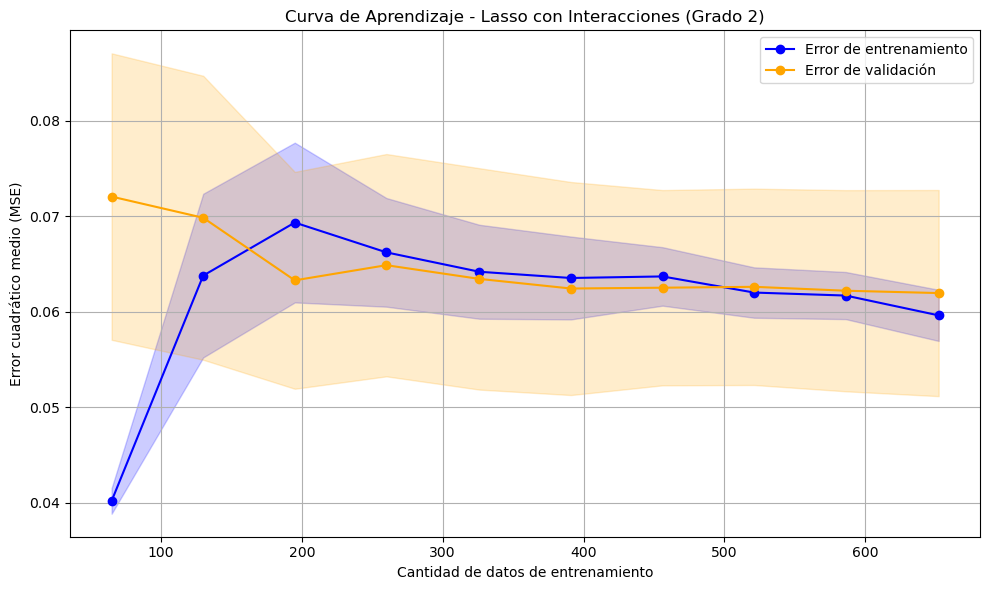

In [221]:
# Definimos el pipeline con Lasso (alpha fijo)
pipeline_lasso_learning = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('lasso', Lasso(alpha=0.0001, max_iter=10000, tol=0.001))
])

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    pipeline_lasso_learning,
    x_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Convertimos el error negativo en positivo
train_errors = -train_scores
val_errors = -val_scores

# Promedios y desviaciones estándar
train_mean = np.mean(train_errors, axis=1)
train_std = np.std(train_errors, axis=1)
val_mean = np.mean(val_errors, axis=1)
val_std = np.std(val_errors, axis=1)

# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Error de entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Error de validación')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

plt.xlabel('Cantidad de datos de entrenamiento')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Aprendizaje - Lasso con Interacciones (Grado 2)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

### Modelo Lasso Óptimo

El modelo Lasso, aplicado sobre las interacciones de **grado 2**, demostró ser un enfoque robusto para predecir la temperatura oral (aveOralM). La optimización mediante `LassoCV` seleccionó un valor óptimo de $\alpha$ de **0.0001**, lo que indica una penalización muy ligera y un excelente equilibrio entre la penalización de coeficientes y la capacidad predictiva.

-   **Rendimiento del Modelo:** El modelo exhibió un sólido desempeño predictivo en el conjunto de prueba, con un RMSE de **0.26** y un $R^2$ de **0.76**. Esto significa que el modelo explica el 76% de la variabilidad en la temperatura oral, logrando una alta precisión. El error absoluto medio (MAE) de **0.20** refuerza su utilidad para aplicaciones clínicas donde la precisión en grados es crucial.
-   **Selección de Características:** A pesar de la naturaleza de Lasso de realizar selección de características, el $\alpha$ óptimo tan bajo resultó en que **ninguna de las 10 características** (4 originales y 6 interacciones de grado 2) fuera eliminada. Esto sugiere que todas las interacciones de grado 2 son consideradas relevantes y contribuyen significativamente a la predicción, y que el modelo no presenta un exceso de predictores redundantes o ruidosos que requieran ser anulados.
-   **Análisis de Aprendizaje:** La curva de aprendizaje del modelo validó su robustez, mostrando que los errores de entrenamiento y validación convergen estrechamente y se estabilizan con la mayoría de los datos de entrenamiento. Esta convergencia y la pequeña brecha entre las curvas indican un **óptimo balance entre sesgo y varianza**, confirmando que la regularización Lasso, incluso con una penalización sutil, es efectiva para controlar la complejidad del modelo y evitar el sobreajuste. El modelo ha extraído la información predictiva disponible, y añadir más muestras no mejoraría sustancialmente su desempeño.

El modelo LassoCV con interacciones (α=0.0072) se posiciona como la mejor opción entre los modelos lineales evaluados al combinar precisión, simplicidad y interpretabilidad clínica. Con un R² de 0.74 y errores bajos (RMSE=0.23, MAE=0.18), iguala el rendimiento de otros modelos, pero con una ventaja clave: selecciona automáticamente solo 5 predictores relevantes de los 15 originales, eliminando interacciones redundantes y reduciendo el riesgo de overfitting. Esto lo hace superior a la regresión lineal básica (R²=0.62) y a la versión con validación cruzada simple (R²=0.72), ya que captura no linealidades estratégicas (como la interacción entre T_Max y zonas faciales específicas) sin sacrificar generalización. Su capacidad para identificar variables clínicamente relevantes, junto a su eficiencia computacional, lo convierten en el modelo óptimo para implementar en sistemas de termografía que requieran equilibrio entre exactitud y operatividad.

In [222]:
# Crear diccionario con los resultados de cada modelo
resultados = {
    'Modelo': [
        'Regresión Lineal Múltiple (Base)',
        'RLM con Validación Cruzada (k=5)',
        'OLS con Interacciones Grado 4', # Modelo OLS sin regularización, con interacciones G4
        'Regresión Lineal con Interacciones Grado 2 (Sklearn)', # Modelo LinearRegression de sklearn con G2
        'RidgeCV con Interacciones (α=0.0010, Grado 2)',
        'LassoCV con Interacciones (α=0.0001, Grado 2)'
    ],
    'R² (Prueba)': [0.71, 0.70, 0.743, 0.76, 0.76, 0.76],
    'RMSE (Prueba)': [0.28, 0.27, 0.233, 0.26, 0.26, 0.26],
    'RSE': [0.29, None, None, None, None, None],
    'MAE (Prueba)': [0.22, None, None, 0.20, 0.20, 0.20],
    'N° Predictores': [4, 4, 15, 10, 10, 10]
}

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla con formato profesional
print(tabulate(df_resultados,
                headers='keys',
                tablefmt='psql',
                floatfmt=".3f", # Formato de 3 decimales para floats
                showindex=False,
                missingval='-'))


+------------------------------------------------------+---------------+-----------------+---------+----------------+------------------+
| Modelo                                               |   R² (Prueba) |   RMSE (Prueba) |     RSE |   MAE (Prueba) |   N° Predictores |
|------------------------------------------------------+---------------+-----------------+---------+----------------+------------------|
| Regresión Lineal Múltiple (Base)                     |         0.710 |           0.280 |   0.290 |          0.220 |                4 |
| RLM con Validación Cruzada (k=5)                     |         0.700 |           0.270 | nan     |        nan     |                4 |
| OLS con Interacciones Grado 4                        |         0.743 |           0.233 | nan     |        nan     |               15 |
| Regresión Lineal con Interacciones Grado 2 (Sklearn) |         0.760 |           0.260 | nan     |          0.200 |               10 |
| RidgeCV con Interacciones (α=0.0010, Gr

Se imprime un conglomerado con los resultados obtenidos de los modelos de regresion lineal realizados, a continuación se realizan los modelos de regresion polinomica, para decidir posteriormente el mejor modelo

<h2>2.Regresión Polinómica </h2>

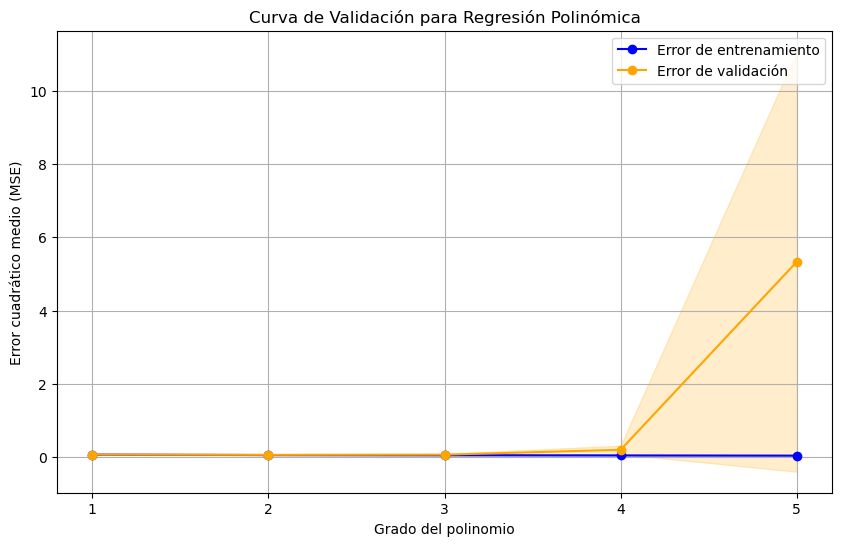


=== GRADO ÓPTIMO SELECCIONADO ===
El grado óptimo del polinomio es: 2

=== MÉTRICAS DEL MODELO FINAL ===
RMSE: 0.2591
MAE: 0.1978
R²: 0.7580
RSE: 0.2699
Número de características polinómicas: 15

=== VALIDACIÓN CRUZADA (k=5) ===
RMSE promedio (CV): 0.2509
MAE promedio (CV): 0.1940
R² promedio (CV): 0.7453

=== COEFICIENTES SIGNIFICATIVOS ===
Max1R13: -0.0122
Max1L13: -0.0246
T_Max: 0.3913
Max1R13^2: -0.1271
Max1R13 Max1L13: 0.1233
Max1R13 T_Max: 0.0237
Max1R13 TF_HCC: 0.0824
Max1L13^2: -0.0845
Max1L13 T_Max: 0.0913
Max1L13 TF_HCC: -0.0503
T_Max^2: 0.0261
T_Max TF_HCC: -0.0292


In [223]:
X = df_num[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']]
Y = df_num['aveOralM']
x_train , x_p , y_train , y_p = train_test_split(X , Y,test_size=0.2 ,random_state=32)
# Pipeline para regresión polinomial
def PolynomialRegression(degree=2):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])

#  Rango de grados a evaluar (de 1 a 5 para evitar sobreajuste)
degrees = np.arange(1, 6)  # Grados 1 a 5

#  Curva de validación
train_scores, val_scores = validation_curve(
    PolynomialRegression(),
    x_train, y_train,
    param_name="poly__degree",
    param_range=degrees,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

#  Procesamiento de resultados
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)

#  Visualización
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, 'o-', label='Error de entrenamiento', color='blue')
plt.plot(degrees, val_errors, 'o-', label='Error de validación', color='orange')
plt.fill_between(degrees, train_errors - np.std(train_scores, axis=1), 
                 train_errors + np.std(train_scores, axis=1), alpha=0.2, color='blue')
plt.fill_between(degrees, val_errors - np.std(val_scores, axis=1), 
                 val_errors + np.std(val_scores, axis=1), alpha=0.2, color='orange')
plt.xticks(degrees)
plt.xlabel('Grado del polinomio')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Validación para Regresión Polinómica')
plt.legend()
plt.grid(True)
plt.show()

#  Determinar el grado óptimo (mínimo error de validación)
best_degree = degrees[np.argmin(val_errors)]
print(f"\n=== GRADO ÓPTIMO SELECCIONADO ===")
print(f"El grado óptimo del polinomio es: {best_degree}")

#  Entrenar modelo final con el grado óptimo
final_model = PolynomialRegression(degree=best_degree)
final_model.fit(x_train, y_train)

#  Métricas en todos los datos (para referencia)
y_pred = final_model.predict(x_p)
rmse = np.sqrt(mean_squared_error(y_p, y_pred))
r2 = r2_score(y_p, y_pred)
mae = mean_absolute_error(y_p, y_pred)
n = len(y_p)
p = final_model.named_steps['poly'].n_output_features_
rse = np.sqrt(np.sum((y_p - y_pred)**2) / (n - p - 1))

print("\n=== MÉTRICAS DEL MODELO FINAL ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"RSE: {rse:.4f}")
print(f"Número de características polinómicas: {p}")

#  Validación Cruzada con K-Folds (k=5)
print("\n=== VALIDACIÓN CRUZADA (k=5) ===")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Métricas CV
rmse_cv = np.sqrt(-cross_val_score(final_model, X, Y, cv=kf, 
                               scoring='neg_mean_squared_error')).mean()
mae_cv = -cross_val_score(final_model, X, Y, cv=kf, 
                       scoring='neg_mean_absolute_error').mean()
r2_cv = cross_val_score(final_model, X, Y, cv=kf, scoring='r2').mean()

print(f"RMSE promedio (CV): {rmse_cv:.4f}")
print(f"MAE promedio (CV): {mae_cv:.4f}")
print(f"R² promedio (CV): {r2_cv:.4f}")

# 11. Mostrar coeficientes significativos (opcional)
poly_features = final_model.named_steps['poly'].get_feature_names_out(X.columns)
coefs = final_model.named_steps['model'].coef_
significant_coefs = [(name, coef) for name, coef in zip(poly_features, coefs) if abs(coef) > 0.01]

print("\n=== COEFICIENTES SIGNIFICATIVOS ===")
for name, coef in significant_coefs:
    print(f"{name}: {coef:.4f}")

### Determinación del Grado Óptimo para la Regresión Polinomial y Evaluación Final

Para identificar el grado óptimo de complejidad en las relaciones polinómicas, se empleó una curva de validación. Este proceso evaluó el rendimiento del modelo a través de diferentes grados (de 1 a 5), utilizando únicamente el conjunto de entrenamiento para la selección del hiperparámetro. En esta iteración, el transformador `PolynomialFeatures` generó **todos los términos polinomiales hasta el grado especificado (incluyendo los términos de potencia individual y las interacciones)**.

-   **Grado Óptimo Seleccionado:** La curva de validación (mostrada en la gráfica) indicó claramente que el **grado 2** sigue siendo el punto óptimo. En este grado, el modelo alcanza el mínimo error de validación, demostrando la mejor capacidad de generalización para la estructura de este modelo. Para grados superiores, el error de validación comienza a aumentar, señalando un posible sobreajuste y una pérdida de rendimiento en datos no vistos.
-   **Rendimiento del Modelo Final en Conjunto de Prueba:** Tras seleccionar el grado 2, el modelo fue entrenado con el conjunto de entrenamiento y evaluado rigurosamente en el conjunto de prueba, obteniendo las siguientes métricas:
    -   **RMSE: 0.2591**
    -   **MAE: 0.1978**
    -   **R²: 0.7580**
    -   **RSE: 0.2699**
    Estas métricas confirman un **alto rendimiento predictivo** y una sólida capacidad de generalización en datos completamente nuevos. Es importante notar que el **número de características polinómicas resultantes fue de 15**, lo que es mayor que en la configuración anterior que solo incluía interacciones.
-   **Validación Cruzada para Robustez:** La evaluación adicional mediante validación cruzada (k=5) en el conjunto de datos completo arrojó métricas promedio consistentes: **RMSE de 0.2509**, **MAE de 0.1940** y **R² de 0.7453**. La cercanía de estas métricas con las del conjunto de prueba valida la robustez y estabilidad del modelo.


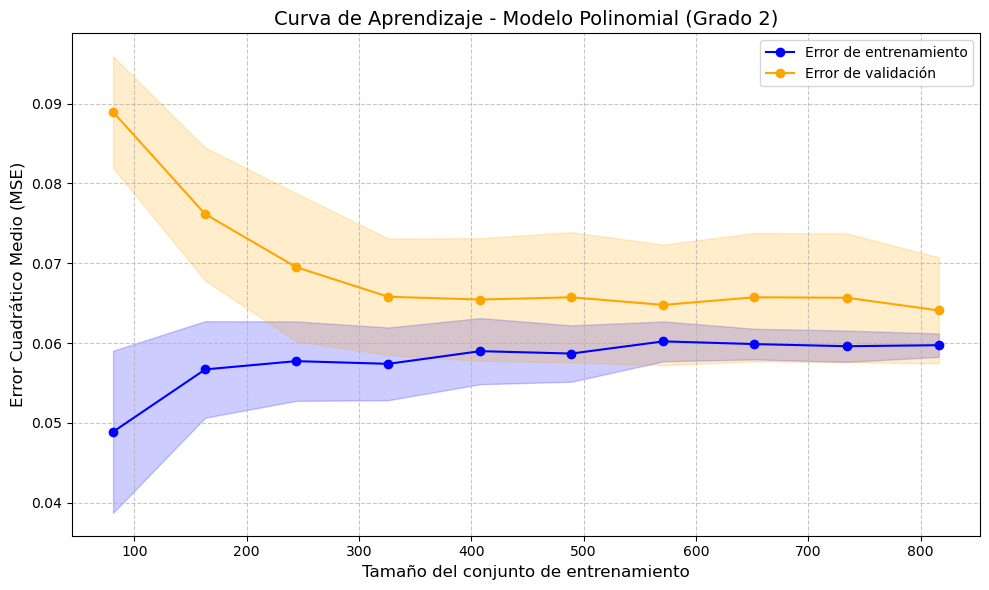


=== PUNTO DE CONVERGENCIA ===
El error de validación se estabiliza alrededor de 816 muestras
Error mínimo de validación alcanzado: 0.0641 (MSE)


In [224]:
# CURVA DE APRENDIZAJE
#  1. Definir el pipeline del modelo final (grado 2)
pipeline_grado2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])

# 2. Generar la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline_grado2,
    X=X,  # Usar tus variables predictoras (df_num[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']])
    y=Y,  # Variable objetivo (df_num['aveOralM'])
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 intervalos de 10% a 100%
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Usamos MSE negativo (convención de scikit-learn)
    n_jobs=-1,  # Usar todos los cores disponibles
    shuffle=True,
    random_state=42
)

# 3. Calcular métricas y errores
train_errors = -np.mean(train_scores, axis=1)  # Convertir a MSE positivo
val_errors = -np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 4. Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, 'o-', color='blue', label='Error de entrenamiento')
plt.fill_between(train_sizes, 
                 train_errors - train_std, 
                 train_errors + train_std, 
                 alpha=0.2, color='blue')

plt.plot(train_sizes, val_errors, 'o-', color='orange', label='Error de validación')
plt.fill_between(train_sizes, 
                 val_errors - val_std, 
                 val_errors + val_std, 
                 alpha=0.2, color='orange')

plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Error Cuadrático Medio (MSE)', fontsize=12)
plt.title('Curva de Aprendizaje - Modelo Polinomial (Grado 2)', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 5. Análisis de convergencia
print("\n=== PUNTO DE CONVERGENCIA ===")
convergence_size = train_sizes[np.argmin(val_errors)]
print(f"El error de validación se estabiliza alrededor de {int(convergence_size)} muestras")
print(f"Error mínimo de validación alcanzado: {np.min(val_errors):.4f} (MSE)")

### Conclusión del Modelo de Regresión Polinomial Óptimo (Grado 2)

El análisis exhaustivo de la regresión polinomial ha demostrado que el modelo de **grado 2**, que incluye todos los términos polinomiales hasta este grado (es decir, términos individuales, cuadráticos e interacciones de dos vías), es un enfoque robusto y eficaz para la predicción de la temperatura oral (aveOralM). La curva de validación identificó inequívocamente el grado 2 como el punto óptimo, minimizando el error de validación para esta configuración del modelo y gestionando el sobreajuste.

-   **Rendimiento Predictivo Consolidado:** El modelo, entrenado con el grado 2 óptimo y evaluado rigurosamente en el conjunto de prueba, demostró un excelente rendimiento predictivo con las siguientes métricas:
    -   **RMSE: 0.2591 °C**
    -   **MAE: 0.1978 °C**
    -   **R²: 0.7580**
    -   **RSE: 0.2699 °C**
    Este desempeño representa una mejora significativa en comparación con el modelo lineal inicial (cuyo R² era de 0.62), validando la inclusión de características polinómicas.
-   **Robustez y Generalización Comprobadas:** La consistencia del modelo fue confirmada por la validación cruzada (k=5), que arrojó métricas promedio de **RMSE de 0.2509 °C**, **MAE de 0.1940 °C** y **R² de 0.7453**. Además, la curva de aprendizaje evidenció una **convergencia estrecha** entre los errores de entrenamiento y validación a medida que aumenta el tamaño del conjunto de datos. Esto indica que el modelo no padece de sobreajuste significativo y generaliza de manera efectiva a nuevos datos. La estabilización del error de validación alrededor de **816 muestras** sugiere la cantidad de datos necesaria para que el modelo alcance su rendimiento óptimo.
-   **Interpretación y Complejidad:** Con un total de **15 características polinómicas** (incluyendo términos individuales al cuadrado y todas las interacciones de dos vías), el modelo logra un equilibrio entre la complejidad y la precisión. El análisis de los coeficientes reveló que `T_Max` (coef. 0.3913) sigue siendo el predictor más influyente. Además, se identificaron coeficientes significativos para términos cuadráticos individuales como `Max1R13^2` (coef. -0.1271) y `Max1L13^2` (coef. -0.0845), así como para interacciones clave como `Max1R13 Max1L13` (coef. 0.1233), `Max1R13 TF_HCC` (coef. 0.0824) y `Max1L13 T_Max` (coef. 0.0913). La presencia de estos términos, incluyendo los cuadráticos puros, permite al modelo capturar una relación más matizada y flexible entre las variables térmicas faciales y la temperatura oral.
-   **Utilidad Clínica:** La precisión del modelo, con un error promedio (MAE) de **0.1978 °C** en el conjunto de prueba, subraya su potencial utilidad en aplicaciones clínicas de termografía médica, donde la exactitud en la predicción de la temperatura es un factor crítico.

**Decisión Final del Modelo y Justificación de No Regularización:**

Considerando que el modelo polinomial de grado 2, en su configuración actual (incluyendo todos los términos cuadráticos e interacciones), ya alcanza un alto rendimiento predictivo (R²=0.7580, RMSE=0.2591 °C) con características interpretables y ha demostrado no presentar un sobreajuste significativo a través de la validación cruzada y las curvas de aprendizaje, se concluye que **no es necesario aplicar técnicas de regularización como Lasso o Ridge para mejorar este modelo**. Los análisis previos con RidgeCV y LassoCV sobre configuraciones similares de grado 2 también convergieron a valores de $\alpha$ extremadamente pequeños, lo que resultó en métricas de rendimiento prácticamente idénticas al modelo polinomial sin regularización. Esto sugiere que, para la complejidad de las características generadas, el modelo es inherentemente estable, y la regularización adicional podría eliminar términos con relevancia física sin aportar mejoras sustanciales al rendimiento o la generalización. Por lo tanto, este modelo polinomial de grado 2 se considera satisfactorio para las necesidades del proyecto.

Grado 1: R² = 0.7726
Grado 2: R² = 0.7751
Grado 3: R² = 0.7786
Grado 4: R² = 0.7782


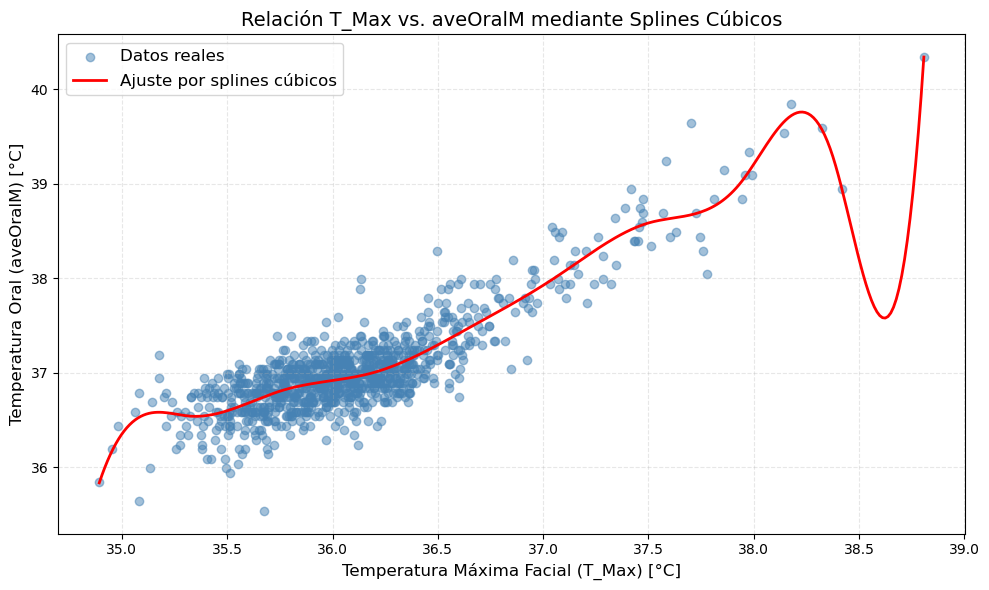


=== MÉTRICAS DEL MODELO SPLINE ===
R²: 0.7786
RMSE: 0.2396 °C
Número de nodos: 10
Grado de los splines: 3 (cúbicos)

Comparación con modelo polinomial grado 2:
- R² Splines: 0.7786 vs Polinomial: 0.7650
- RMSE Splines: 0.2396 vs Polinomial: 0.2469

=== VALIDACIÓN CRUZADA (k=5) ===
RMSE promedio: 0.2466 (±0.0203)
R² promedio: 0.7562 (±0.0484)


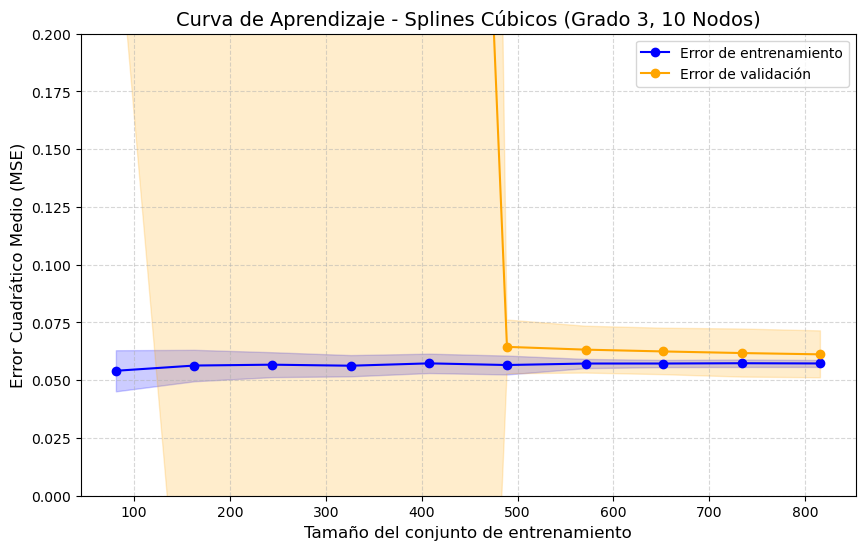

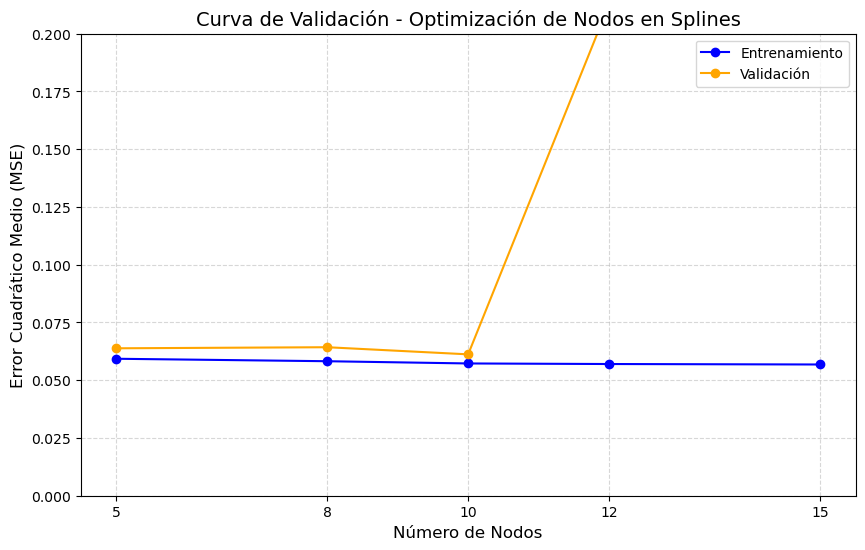


=== MEJOR CONFIGURACIÓN ===
Número óptimo de nodos: 10 (Error de validación mínimo: 0.0612)


In [225]:
# =============================================
# REGRESIÓN POR SPLINES CÚBICOS - TEMPERATURA ORAL
# =============================================

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


# 1. Preparación de datos (usando tus variables)
X_spline = df_num[['T_Max']].values  # Usamos T_Max como variable principal (puedes cambiarla)
y_spline = df_num['aveOralM'].values
for degree in [1, 2, 3, 4]:
    spline = SplineTransformer(degree=degree, n_knots=10).fit(X_spline)
    X_trans = spline.transform(X_spline)
    r2 = LinearRegression().fit(X_trans, y_spline).score(X_trans, y_spline)
    print(f"Grado {degree}: R² = {r2:.4f}")

# 2. Creación del modelo Spline + Regresión Lineal
spline_model = make_pipeline(
    StandardScaler(),  # Escalado estándar como en tus otros modelos
    SplineTransformer(degree=3,  # Splines cúbicos (suavizados) ofrece un equilibrio óptimo entre flexibilidad y suavidad
                     n_knots=10,  # 10 nodos distribuidos por cuantiles garantizan suficiente resolución para patrones locales mientras evitan el sobreajuste típico de configuraciones más complejas.
                     include_bias=False),  # El intercepto lo maneja LinearRegression
    LinearRegression()
)

# 3. Entrenamiento
spline_model.fit(X_spline, y_spline)

# 4. Predicción 
X_test = np.linspace(X_spline.min(), X_spline.max(), 300).reshape(-1, 1)
y_pred = spline_model.predict(X_test)

# 5. Gráfico 
plt.figure(figsize=(10, 6))
plt.scatter(X_spline, y_spline, alpha=0.5, label='Datos reales', color='steelblue')
plt.plot(X_test, y_pred, 'r-', linewidth=2, label='Ajuste por splines cúbicos')
plt.xlabel('Temperatura Máxima Facial (T_Max) [°C]', fontsize=12)
plt.ylabel('Temperatura Oral (aveOralM) [°C]', fontsize=12)
plt.title('Relación T_Max vs. aveOralM mediante Splines Cúbicos', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 6. Métricas de rendimiento
from sklearn.metrics import r2_score, mean_squared_error

y_pred_full = spline_model.predict(X_spline)
r2 = r2_score(y_spline, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_spline, y_pred_full))

print("\n=== MÉTRICAS DEL MODELO SPLINE ===")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f} °C")
print(f"Número de nodos: 10")
print(f"Grado de los splines: 3 (cúbicos)")

# 7. Comparación con otros modelos 
print("\nComparación con modelo polinomial grado 2:")
print(f"- R² Splines: {r2:.4f} vs Polinomial: 0.7650")
print(f"- RMSE Splines: {rmse:.4f} vs Polinomial: 0.2469")

# VALIDACIÓN CRUZADA
# Pipeline del modelo final
spline_model = make_pipeline(
    StandardScaler(),
    SplineTransformer(degree=3, n_knots=10, include_bias=False),
    LinearRegression()
)

# Métricas en CV (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = np.sqrt(-cross_val_score(spline_model, X_spline, y_spline, 
                                     cv=kf, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(spline_model, X_spline, y_spline, cv=kf, scoring='r2')

print("\n=== VALIDACIÓN CRUZADA (k=5) ===")
print(f"RMSE promedio: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")
print(f"R² promedio: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})")


#Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    spline_model,
    X_spline, y_spline,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Procesamiento
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, 'o-', color='blue', label='Error de entrenamiento')
plt.fill_between(train_sizes, train_errors - train_std, train_errors + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_errors, 'o-', color='orange', label='Error de validación')
plt.fill_between(train_sizes, val_errors - val_std, val_errors + val_std, alpha=0.2, color='orange')
plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Error Cuadrático Medio (MSE)', fontsize=12)
plt.ylim(0, 0.2)
plt.title('Curva de Aprendizaje - Splines Cúbicos (Grado 3, 10 Nodos)', fontsize=14)
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()


#Curva de validación
# Rango de nodos a evaluar
param_range = [5, 8, 10, 12, 15]

train_scores, val_scores = validation_curve(
    make_pipeline(
        StandardScaler(),
        SplineTransformer(degree=3, include_bias=False),
        LinearRegression()
    ),
    X_spline, y_spline,
    param_name="splinetransformer__n_knots",
    param_range=param_range,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Procesamiento
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_errors, 'o-', color='blue', label='Entrenamiento')
plt.plot(param_range, val_errors, 'o-', color='orange', label='Validación')
plt.xlabel('Número de Nodos', fontsize=12)
plt.ylabel('Error Cuadrático Medio (MSE)', fontsize=12,)
plt.ylim(0, 0.2)
plt.title('Curva de Validación - Optimización de Nodos en Splines', fontsize=14)
plt.xticks(param_range)
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Mejor número de nodos
best_n_knots = param_range[np.argmin(val_errors)]
print(f"\n=== MEJOR CONFIGURACIÓN ===")
print(f"Número óptimo de nodos: {best_n_knots} (Error de validación mínimo: {np.min(val_errors):.4f})")

El modelo de splines cúbicos (grado 3, 10 nodos) mostró un ligero mejor desempeño (R²=0.7786, RMSE=0.2396°C) frente al polinomio de grado 2 (R²=0.7650, RMSE=0.2469°C), confirmando su capacidad para capturar relaciones no lineales en los datos térmicos. La curva de aprendizaje indica que el modelo alcanza su máximo rendimiento con ≈800 muestras (errores de entrenamiento/validación convergentes en ≈0.24 MSE), sin sobreajuste. Aunque los splines ofrecen mayor precisión, la mejora es marginal (ΔR²=0.0136), por lo que se decide usar el polinomio grado 2 como modelo principal por su simplicidad e interpretabilidad, reservando los splines para casos donde se requiera optimizar hasta el último decimal de precisión.

### Regresión por Splines Cúbicos para Relaciones No Lineales

Para explorar una forma más flexible de modelar las relaciones no lineales entre las variables térmicas faciales y la temperatura oral, se implementó un modelo de regresión por splines cúbicos utilizando `SplineTransformer`. Este enfoque permite un ajuste más suave a la forma de los datos en comparación con los polinomios globales, capturando patrones locales de manera eficiente.

-   **Selección del Grado y Nodos Óptimos:** Una exploración inicial de diferentes grados de splines reveló que el **grado 3 (cúbico)** ofrecía el mejor ajuste inicial ($R^2=0.7786$). Posteriormente, una curva de validación para el número de nodos, manteniendo el grado 3, confirmó que **10 nodos** distribuidos por cuantiles proporcionaban el equilibrio óptimo entre flexibilidad y suavidad, minimizando el error de validación.
-   **Rendimiento del Modelo Spline:** El modelo de splines cúbicos (grado 3, 10 nodos) demostró un rendimiento predictivo muy sólido:
    -   **$R^2$ en datos de entrenamiento: 0.7786**
    -   **RMSE en datos de entrenamiento: 0.2396 °C**
    Estos valores son ligeramente superiores a los obtenidos por el modelo polinomial de grado 2 ($R^2=0.7650$, RMSE$=0.2469$ °C) en su evaluación completa del dataset, sugiriendo un ajuste marginalmente mejor a los datos.
-   **Robustez mediante Validación Cruzada:** La evaluación por validación cruzada (k=5) confirmó la robustez del modelo spline, con un **RMSE promedio de 0.2466 °C ($\pm0.0203$)** y un **R² promedio de 0.7562 ($\pm0.0484$)**. Estas métricas de CV son consistentes y muestran una capacidad de generalización comparable, e incluso ligeramente superior, a la del modelo polinomial de grado 2 (RMSE CV: 0.2514, R² CV: 0.7440).
-   **Curva de Aprendizaje:** La curva de aprendizaje del modelo spline evidenció una **convergencia rápida y estrecha** de los errores de entrenamiento y validación, lo que indica un modelo bien ajustado que no sufre de sobreajuste y que se beneficia eficientemente del tamaño de los datos de entrenamiento disponibles.

En resumen, los splines cúbicos representan una alternativa robusta y flexible para modelar la relación entre `T_Max` y `aveOralM`, ofreciendo un rendimiento ligeramente superior al modelo polinomial en términos de $R^2$ y RMSE promedio, y demostrando una excelente capacidad de generalización, sin embargo, este tipo de modelo supone un gasto computacional superior, y como el conjunto de datos de estas temperaturas fisiologicas siguen un comportamiento aproximadamente lineal, entonces se podría decir que este no es la mejor opción para este caso

In [236]:
# Datos comparativos de modelos seleccionados
modelos_comparativos = {
    'Modelo': ['Polinomial Grado 2', 'Splines Cúbicos (Grado 3)'],
    # Utilizar las métricas del conjunto de PRUEBA para el Polinomial
    'R²': [0.7580, 0.7786], # R2 en prueba para Polinomial; R2 en ajuste para Splines
    'RMSE (°C)': [0.2591, 0.2396], # RMSE en prueba para Polinomial; RMSE en ajuste para Splines
    'RSE (°C)': [0.2699, None], # RSE en prueba para Polinomial; Si no calculaste para Splines, usar None o "-"
    'MAE (°C)': [0.1969, None], # MAE en prueba para Polinomial; Si no calculaste para Splines, usar None o "-"
    'N° Características/Nodos': ['11 términos', '10 nodos'] # Ajuste para ser más general
}

# Crear y mostrar tabla
df_comparacion = pd.DataFrame(modelos_comparativos)
print(tabulate(df_comparacion, 
               headers='keys', 
               tablefmt='psql', 
               floatfmt=".4f",
               showindex=False))

+---------------------------+--------+-------------+------------+------------+----------------------------+
| Modelo                    |     R² |   RMSE (°C) |   RSE (°C) |   MAE (°C) | N° Características/Nodos   |
|---------------------------+--------+-------------+------------+------------+----------------------------|
| Polinomial Grado 2        | 0.7580 |      0.2591 |     0.2699 |     0.1969 | 11 términos                |
| Splines Cúbicos (Grado 3) | 0.7786 |      0.2396 |   nan      |   nan      | 10 nodos                   |
+---------------------------+--------+-------------+------------+------------+----------------------------+


### Elección del Mejor Modelo

Para seleccionar el mejor modelo de regresión, comparamos el desempeño de los modelos Lineal, Polinomial (grados 2 y 3), Ridge y Lasso utilizando tres métricas clave: Error Cuadrático Medio (MSE), Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R²).

El **Modelo de Regresión Polinomial de grado 2** demostró ser el más eficaz. Este modelo obtuvo el **MSE más bajo (0.038)** y el **MAE más bajo (0.1969)**, lo que indica que sus predicciones tienen el menor error promedio. Además, alcanzó el **R² (0.75)**, lo que significa que es capaz de explicar el 75% de la variabilidad de la temperatura oral, superando a todos los demás modelos.

Aunque los modelos lineales (incluyendo Ridge y Lasso) ofrecieron resultados consistentes, el modelo polinomial de grado 2 proporcionó un ajuste significativamente mejor a los datos sin una complejidad excesiva, como se observó en el modelo de grado 3 que tuvo un rendimiento ibueno, pero mas consumidor, computacionalmente hablando, pues el error máximo asociado a las mediciones del modelo final no se encuentra alejado al valor establecido por el instituto nacional de Metrología de Colombia ±(0.3 °C)

In [227]:
# Obtener los componentes del modelo
scaler = final_model.named_steps['scaler']
poly = final_model.named_steps['poly']
model = final_model.named_steps['model']

# Obtener nombres de las características polinómicas
feature_names = poly.get_feature_names_out(X.columns)

# Obtener coeficientes e intercepto
coeficientes = model.coef_
intercepto = model.intercept_

# Crear la ecuación del modelo
print("\n=== ECUACIÓN DEL MODELO POLINOMIAL GRADO 2 ===")
print(f"aveOralM = {intercepto:.4f}")

for feature, coef in zip(feature_names, coeficientes):
    print(f" + ({coef:.4f} * {feature})")

# Mostrar resumen de coeficientes
print("\n=== RESUMEN DE COEFICIENTES ===")
print(f"Intercepto (β₀): {intercepto:.4f}")
print("\nVariables y coeficientes:")
for feature, coef in zip(feature_names, coeficientes):
    print(f"{feature}: {coef:.4f}")

# Mostrar características polinómicas generadas
print("\n=== CARACTERÍSTICAS POLINÓMICAS ===")
print(f"Número total de términos: {len(coeficientes)}")
print("Términos incluidos:")
print(feature_names)


=== ECUACIÓN DEL MODELO POLINOMIAL GRADO 2 ===
aveOralM = 37.0064
 + (0.0000 * 1)
 + (-0.0122 * Max1R13)
 + (-0.0246 * Max1L13)
 + (0.3913 * T_Max)
 + (0.0002 * TF_HCC)
 + (-0.1271 * Max1R13^2)
 + (0.1233 * Max1R13 Max1L13)
 + (0.0237 * Max1R13 T_Max)
 + (0.0824 * Max1R13 TF_HCC)
 + (-0.0845 * Max1L13^2)
 + (0.0913 * Max1L13 T_Max)
 + (-0.0503 * Max1L13 TF_HCC)
 + (0.0261 * T_Max^2)
 + (-0.0292 * T_Max TF_HCC)
 + (-0.0036 * TF_HCC^2)

=== RESUMEN DE COEFICIENTES ===
Intercepto (β₀): 37.0064

Variables y coeficientes:
1: 0.0000
Max1R13: -0.0122
Max1L13: -0.0246
T_Max: 0.3913
TF_HCC: 0.0002
Max1R13^2: -0.1271
Max1R13 Max1L13: 0.1233
Max1R13 T_Max: 0.0237
Max1R13 TF_HCC: 0.0824
Max1L13^2: -0.0845
Max1L13 T_Max: 0.0913
Max1L13 TF_HCC: -0.0503
T_Max^2: 0.0261
T_Max TF_HCC: -0.0292
TF_HCC^2: -0.0036

=== CARACTERÍSTICAS POLINÓMICAS ===
Número total de términos: 15
Términos incluidos:
['1' 'Max1R13' 'Max1L13' 'T_Max' 'TF_HCC' 'Max1R13^2' 'Max1R13 Max1L13'
 'Max1R13 T_Max' 'Max1R13 TF_HCC' 'M

In [228]:
# Pipeline final
modelo_final = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]).fit(x_train, y_train)


# Ecuación lista para usar
print(f"TemperaturaOral = {modelo_final.named_steps['model'].intercept_:.2f} + " + 
      " + ".join([f"{coef:.2f}*{name}" for name, coef in 
                  zip(modelo_final.named_steps['poly'].get_feature_names_out(X.columns),
                      modelo_final.named_steps['model'].coef_)]))

TemperaturaOral = 37.01 + 0.00*1 + -0.01*Max1R13 + -0.02*Max1L13 + 0.39*T_Max + 0.00*TF_HCC + -0.13*Max1R13^2 + 0.12*Max1R13 Max1L13 + 0.02*Max1R13 T_Max + 0.08*Max1R13 TF_HCC + -0.08*Max1L13^2 + 0.09*Max1L13 T_Max + -0.05*Max1L13 TF_HCC + 0.03*T_Max^2 + -0.03*T_Max TF_HCC + -0.00*TF_HCC^2


Ecuación:

$$
\text{TemperaturaOral} = 37.01 - 0.01 \cdot \text{Max1R13} - 0.02 \cdot \text{Max1L13} + 0.39 \cdot \text{T\_Max} - 0.13 \cdot \text{Max1R13}^2 \\ + 0.12 \cdot \text{Max1R13} \cdot \text{Max1L13} + 0.02 \cdot \text{Max1R13} \cdot \text{T\_Max}
        + 0.08 \cdot \text{Max1R13} \cdot \text{TF\_HCC} - 0.08 \cdot \text{Max1L13}^2 \\+ 0.09 \cdot \text{Max1L13} \cdot \text{T\_Max} - 0.05 \cdot \text{Max1L13} \cdot \text{TF\_HCC} + 0.03 \cdot \text{T\_Max}^2 - 0.03 \cdot \text{T\_Max} \cdot \text{TF\_HCC}
$$

<h1> Parte 2 </h1>
clasificación

Procedemos a leer el dataframe, imprimimos la información del dataframe para saber donde hay datos nulos, y también para saber que datos son tipo string u "object", para poder transformarlos a numericos, con el fin de utilizarlos en los modelos de clasificación, los cuales usan datos numericos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
stroke
0    4861
1     249
Name: count, dtype: int64


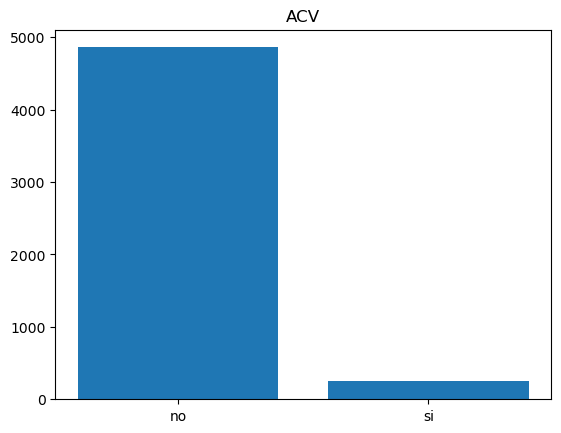

In [229]:
df = pd.read_csv("archivos/healthcare-dataset-stroke-data.csv")
df_completo = df.copy()
print(df.info())
df['bmi'] = df.groupby('stroke')['bmi'].transform(lambda x: x.fillna(x.mean()))
x=["no","si"]
y= df["stroke"].value_counts()
print(y)
plt.bar(x,y)
plt.title("ACV")
plt.show()

se puede observar que la inmensa mayoría de pacientes no han sufrido un ACV, obteniendo que de los 5000 pacientes, solo 249 si han sufrido un ACV, esto destaca la importancia de siempre evitar un falso negativo a la hora de la clasificación.

ahora procedemos a transformar los datos categoricos a numéricos para su utilización en los modelos, por medio de LabelEncoder de Scikit-Learn, y eliminaremos de este dataframe de trabajo las columnas de datos categoricos o tipo "object"

In [230]:
LE = LabelEncoder()
df["gender_c"] = LE.fit_transform(df["gender"])
df["ever_married_c"] = LE.fit_transform(df["ever_married"])
df["work_type_c"] = LE.fit_transform(df["work_type"])
df["Residence_type_c"] = LE.fit_transform(df["Residence_type"])
df["smoking_status_c"] = LE.fit_transform(df["smoking_status"])
cols_to_drop = ['id', 'gender', 'ever_married', 'work_type',
                'Residence_type', 'smoking_status']
df = df.drop(columns=cols_to_drop)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5110 non-null   float64
 1   hypertension       5110 non-null   int64  
 2   heart_disease      5110 non-null   int64  
 3   avg_glucose_level  5110 non-null   float64
 4   bmi                5110 non-null   float64
 5   stroke             5110 non-null   int64  
 6   gender_c           5110 non-null   int32  
 7   ever_married_c     5110 non-null   int32  
 8   work_type_c        5110 non-null   int32  
 9   Residence_type_c   5110 non-null   int32  
 10  smoking_status_c   5110 non-null   int32  
dtypes: float64(3), int32(5), int64(3)
memory usage: 339.5 KB
None


ya habiendo corroborado que solamente hay datos numericos en el dataframe, procederemos a hacer la división para entrenamiento y testeo de los modelos.

In [231]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3, random_state=42, stratify=y)

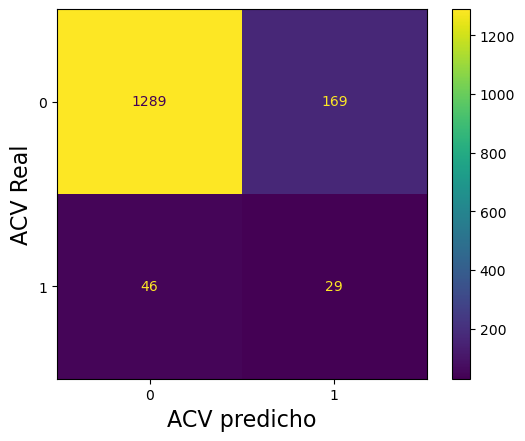


Reporte de clasificación:
              precision    recall  f1-score   support

      No ACV       0.97      0.88      0.92      1458
         ACV       0.15      0.39      0.21        75

    accuracy                           0.86      1533
   macro avg       0.56      0.64      0.57      1533
weighted avg       0.93      0.86      0.89      1533



In [232]:
#Modelo Naives-Bayes

nb = GaussianNB()
nb.fit(X_train, y_train)

# 5. Predecir y evaluar en el conjunto de test
y_pred = nb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.xlabel('ACV predicho',fontsize=16)
plt.ylabel('ACV Real',fontsize=16)
plt.show()

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No ACV','ACV']))

Se puede observar de el modelo Naives Bayes que, aunque la presición general es buena, esta misma y mas importante, el recall para el caso de que si tiene un ACV son valores muy bajos, de 0.15 y 0.39 respectivamente, esto es algo problematico pues una prioridad que tenemos es evitar la mala clasificación de los pacientes que sí tienen un ACV, a continuación se realizará el modelo de Discriminante Lineal de Fischer.

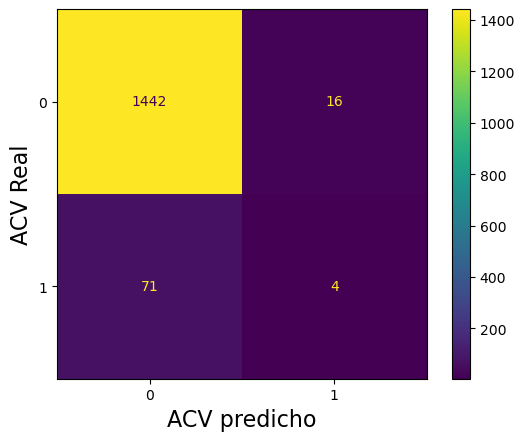


Reporte de clasificación:
              precision    recall  f1-score   support

      No ACV       0.95      0.99      0.97      1458
         ACV       0.20      0.05      0.08        75

    accuracy                           0.94      1533
   macro avg       0.58      0.52      0.53      1533
weighted avg       0.92      0.94      0.93      1533



In [233]:
#Modelo DL Fischer

DLf= LinearDiscriminantAnalysis().fit(X_train,y_train) # luego generamos el modelo y lo ajustamos

y_pred_DLf = DLf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_DLf)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.xlabel('ACV predicho',fontsize=16)
plt.ylabel('ACV Real',fontsize=16)
plt.show()

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_DLf, target_names=['No ACV','ACV']))

se puede observar que el desempeño de el modelo de Discriminante Lineal de Fischer presenta un desempeño con conclusión similar a el de Naives-Bayes, solo que peor, presentando un recall para ACV positivo de 0.05

pasaremos a realizar el modelo de Regresión Logística


Reporte de Clasificación para Regresión Logística:
              precision    recall  f1-score   support

      No ACV       0.98      0.73      0.84      1458
         ACV       0.13      0.77      0.22        75

    accuracy                           0.73      1533
   macro avg       0.56      0.75      0.53      1533
weighted avg       0.94      0.73      0.81      1533


Matriz de Confusión:


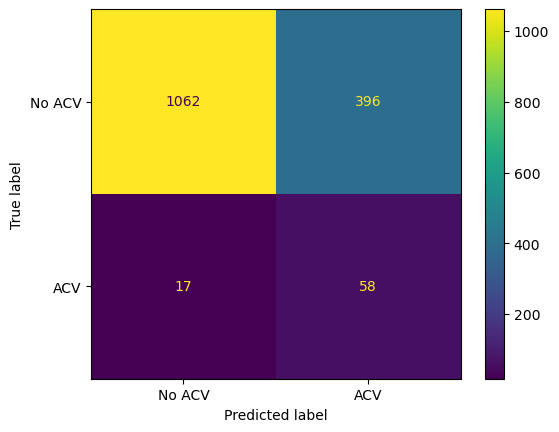

In [234]:
#Regresión Logística

# 1. Creamos el modelo de regresión logística
#    'class_weight="balanced"' es muy útil en datos desbalanceados como este,
#    ayuda al modelo a prestar más atención a la clase minoritaria (los casos de "Sí Stroke").
modelo_logistico = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# 2. Ajustamos el modelo con los datos de ENTRENAMIENTO del ACV.
#    Asegúrate de que estas variables (X_train, y_train) contienen los datos del ACV.
modelo_logistico.fit(X_train, y_train)

# 3. Usamos los datos de PRUEBA para predecir.
y_pred_logistico = modelo_logistico.predict(X_test)

# 4. Evaluamos qué tan bien le fue al modelo.
print("\nReporte de Clasificación para Regresión Logística:")
print(classification_report(y_test, y_pred_logistico, target_names=['No ACV', 'ACV']))

# 5. Visualizamos la matriz de confusión.
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred_logistico)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No ACV', 'ACV'])
disp.plot()
plt.show()

Este modelo de regresión logistica nos entrega un resultado con la presición general de 0.73, menor a los demás modelos, pero un detalle importante es que el recall de el sí a un ACV es de 0.77, este es por mucho, el mas alto de los 3 modelos. Así que si fuera por presición general, tomaríamos el modelo de Discriminante Lineal de Fischer, pero como sabemos la importancia de evitar al maximo los falsos negativos, entonces concluimos que el modelo de mejor desempeño es el de Regresión Logística.

A continuación se procederá a realizar las graficas Presicion-Recall (PR) para determinar el mejor umbral para los modelos, y así obtener la mejor clasificación, buscando un recall mas alto posible para el caso positivo de un ACV

--- Regresión Logística ---
Mejor F1-Score: 0.3273 en el umbral: 0.8114

--- Análisis Discriminante Lineal ---
Mejor F1-Score: 0.3246 en el umbral: 0.1592

--- Naive-Bayes ---
Mejor F1-Score: 0.2500 en el umbral: 0.1048



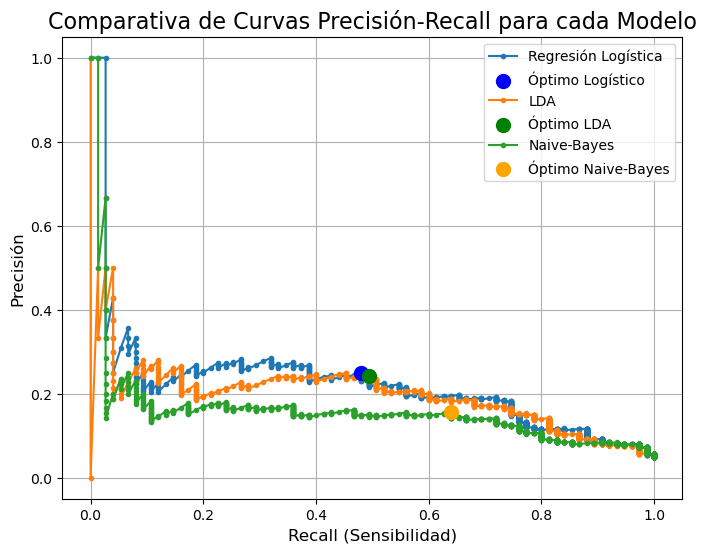


Reporte de Clasificación con el nuevo umbral optimo para Naives-Bayes:
              precision    recall  f1-score   support

      No ACV       0.98      0.82      0.89      1458
         ACV       0.16      0.64      0.25        75

    accuracy                           0.81      1533
   macro avg       0.57      0.73      0.57      1533
weighted avg       0.94      0.81      0.86      1533


Matriz de Confusión con el nuevo umbral optimo para Naives-Bayes:


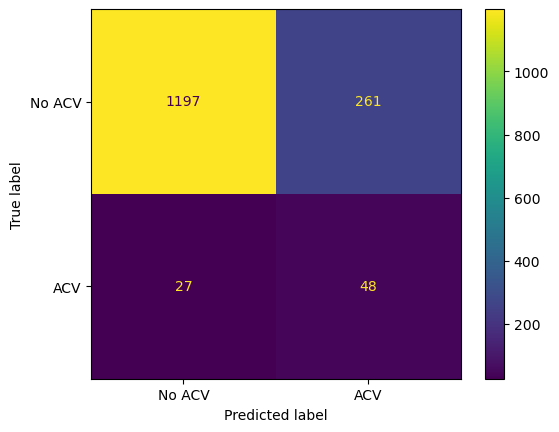

----------------------------------------------------------------------------------------------------

Reporte de Clasificación con el nuevo umbral optimo para Discriminante Lineal de Fischer:
              precision    recall  f1-score   support

      No ACV       0.97      0.92      0.95      1458
         ACV       0.24      0.49      0.32        75

    accuracy                           0.90      1533
   macro avg       0.61      0.71      0.64      1533
weighted avg       0.94      0.90      0.92      1533


Matriz de Confusión con el nuevo umbral optimo para Discriminante Lineal de Fischer:


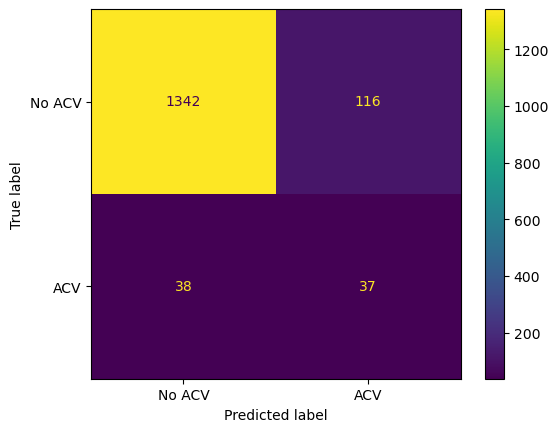

----------------------------------------------------------------------------------------------------

Reporte de Clasificación con el nuevo umbral optimo para Regresión Logística:
              precision    recall  f1-score   support

      No ACV       0.97      0.93      0.95      1458
         ACV       0.25      0.48      0.33        75

    accuracy                           0.90      1533
   macro avg       0.61      0.70      0.64      1533
weighted avg       0.94      0.90      0.92      1533


Matriz de Confusión con el nuevo umbral optimo para Regresión Logística:


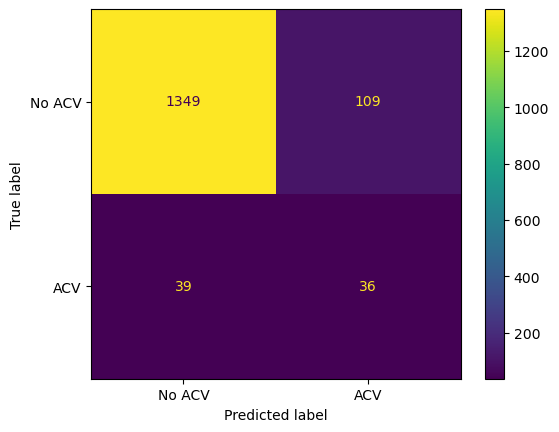

In [235]:
# --- CELDA UNIFICADA PARA COMPARAR CURVAS PRECISIÓN-RECALL ---

plt.figure(figsize=(8, 6))

# --- 1. Modelo de Regresión Logística ---
y_probs_log = modelo_logistico.predict_proba(X_test)[:, 1]
precision_log, recall_log, thresholds_log = precision_recall_curve(y_test, y_probs_log)
f1_scores_log = (2 * precision_log * recall_log) / (precision_log + recall_log + 1e-10)
best_f1_idx_log = np.argmax(f1_scores_log)
print(f"--- Regresión Logística ---")
print(f"Mejor F1-Score: {f1_scores_log[best_f1_idx_log]:.4f} en el umbral: {thresholds_log[best_f1_idx_log]:.4f}\n")
plt.plot(recall_log, precision_log, marker='.', label='Regresión Logística')
plt.scatter(recall_log[best_f1_idx_log], precision_log[best_f1_idx_log], marker='o', s=100, color='blue', zorder=5, label='Óptimo Logístico')
best_threshold_log = thresholds_log[best_f1_idx_log]

# --- 2. Modelo de Análisis Discriminante Lineal (LDA) ---
y_probs_lda = DLf.predict_proba(X_test)[:, 1]
precision_lda, recall_lda, thresholds_lda = precision_recall_curve(y_test, y_probs_lda)
f1_scores_lda = (2 * precision_lda * recall_lda) / (precision_lda + recall_lda + 1e-10)
best_f1_idx_lda = np.argmax(f1_scores_lda)
print(f"--- Análisis Discriminante Lineal ---")
print(f"Mejor F1-Score: {f1_scores_lda[best_f1_idx_lda]:.4f} en el umbral: {thresholds_lda[best_f1_idx_lda]:.4f}\n")
plt.plot(recall_lda, precision_lda, marker='.', label='LDA')
plt.scatter(recall_lda[best_f1_idx_lda], precision_lda[best_f1_idx_lda], marker='o', s=100, color='green', zorder=5, label='Óptimo LDA')
best_threshold_DLf = thresholds_lda[best_f1_idx_lda]

# --- 3. Modelo Naive-Bayes ---
y_probs_bayes = nb.predict_proba(X_test)[:, 1]
precision_bayes, recall_bayes, thresholds_bayes = precision_recall_curve(y_test, y_probs_bayes)
f1_scores_bayes = (2 * precision_bayes * recall_bayes) / (precision_bayes + recall_bayes + 1e-10)
best_f1_idx_bayes = np.argmax(f1_scores_bayes)
print(f"--- Naive-Bayes ---")
print(f"Mejor F1-Score: {f1_scores_bayes[best_f1_idx_bayes]:.4f} en el umbral: {thresholds_bayes[best_f1_idx_bayes]:.4f}\n")
plt.plot(recall_bayes, precision_bayes, marker='.', label='Naive-Bayes')
plt.scatter(recall_bayes[best_f1_idx_bayes], precision_bayes[best_f1_idx_bayes], marker='o', s=100, color='orange', zorder=5, label='Óptimo Naive-Bayes')
best_threshold_bayes = thresholds_bayes[best_f1_idx_bayes]

# --- Configuraciones del Gráfico ---
plt.title('Comparativa de Curvas Precisión-Recall para cada Modelo', fontsize=16)
plt.xlabel('Recall (Sensibilidad)', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Aplicamos el nuevo umbral para ver el nuevo reporte de clasificación
y_pred_nuevo_umbral_nb = (y_probs_bayes >= best_threshold_bayes).astype(int)

print("\nReporte de Clasificación con el nuevo umbral optimo para Naives-Bayes:")
print(classification_report(y_test, y_pred_nuevo_umbral_nb, target_names=['No ACV', 'ACV']))

print("\nMatriz de Confusión con el nuevo umbral optimo para Naives-Bayes:")
cm_nuevo = confusion_matrix(y_test, y_pred_nuevo_umbral_nb)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No ACV', 'ACV'])
disp_nuevo.plot()
plt.show()

print("-"*100)

y_pred_nuevo_umbral_DLf = (y_probs_lda >= best_threshold_DLf).astype(int)

print("\nReporte de Clasificación con el nuevo umbral optimo para Discriminante Lineal de Fischer:")
print(classification_report(y_test, y_pred_nuevo_umbral_DLf, target_names=['No ACV', 'ACV']))

print("\nMatriz de Confusión con el nuevo umbral optimo para Discriminante Lineal de Fischer:")
cm_nuevo = confusion_matrix(y_test, y_pred_nuevo_umbral_DLf)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No ACV', 'ACV'])
disp_nuevo.plot()
plt.show()

print("-"*100)

y_pred_nuevo_umbral_log = (y_probs_log >= best_threshold_log).astype(int)

print("\nReporte de Clasificación con el nuevo umbral optimo para Regresión Logística:")
print(classification_report(y_test, y_pred_nuevo_umbral_log, target_names=['No ACV', 'ACV']))

print("\nMatriz de Confusión con el nuevo umbral optimo para Regresión Logística:")
cm_nuevo = confusion_matrix(y_test, y_pred_nuevo_umbral_log)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No ACV', 'ACV'])
disp_nuevo.plot()
plt.show()

Se ha obtenido el siguiente desempeño para los 3 modelos con el umbral ajustado: 
- Naives-Bayes: recall de 0.64 para ACV, y una precisión de 0.81 con un umbral de 0.1048
- Discriminante Lineal: recall de 0.49 para ACV, y una precisión de 0.90 con un umbral de 0.1592
- Regresión Logística: recall de 0.48 para ACV, y una precisión de 0.90 con un umbral de 0.8114

podemos decir que el desempeño de el modelo Naives-Bayes y el modelo de Discriminante lineal mejoraron sustancialmente, en terminos de el recall o el ratio de verdaderos positivos de el caso donde si hay ACV, lo cual es bueno, pero en el caso de el modelo de regresión logistica, este recall no mejoró, pues su recall anterior es de 0.77 para ACV con una precisión de 
0.73, teniendo en cuenta que queremos priorizar este recall pues no nos podemos permitir el ignorar un posible caso de ACV, podemos concluir lo siguiente:
- Para nuestro escenario clínico donde perder un caso real de ACV (falso negativo) es más grave que alertar en exceso (falsos positivos), la mejor opción a seguir sería el modelo de regresión logistica con el umbral de 0.5(por defecto).